In [0]:
#import MeCab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import tensorflow as tf
import keras

import time
import statistics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
#Google Colabでデータの読み込みを行うときに必要なもの
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("/content/drive")
os.getcwd()

'/content/drive'

In [0]:
!pwd

/content/drive


In [0]:
!ls -l

total 4
drwx------ 8 root root 4096 May 29 19:04 'My Drive'


In [0]:
os.chdir("/content/drive/My Drive")
!ls -l

total 24
drwx------ 2 root root 4096 Apr 29 18:37 メイアビ
drwx------ 2 root root 4096 May 23 14:57 B-fat_竹井
drwx------ 2 root root 4096 Mar 19 05:04 企画書
drwx------ 2 root root 4096 Apr  3 08:01 写真
drwx------ 2 root root 4096 Feb 27 04:30 数学科教育法Ⅳ
drwx------ 2 root root 4096 May 29 17:53 言語処理100本Knocks


In [0]:
os.chdir("/content/drive/My Drive/言語処理100本Knocks")

In [0]:
!nvidia-smi

Sat May 30 16:39:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## 第80問

In [0]:
import collections

In [0]:
train = pd.read_csv("Part6_Result/train.txt",sep="\t",header=None)
valid = pd.read_csv("Part6_Result/valid.txt",sep="\t",header=None)
test = pd.read_csv("Part6_Result/test.txt",sep="\t",header=None)

X_train = train.iloc[:,0]
X_valid = valid.iloc[:,0]
X_test = test.iloc[:,0]


#関数その1 : 学習等に使う多次元配列の生成を行う関数、もちろん小文字に統一
def get_word_list_True(X_df):
    ans = []
    Ans = []
    for i,text in enumerate(X_df):
        if i == 0: #データの1行目にラベル名を残してしまったので、その部分は飛ばす
            continue
        else :
            words = text.split(" ")
            ans.append(words)
            
    #単語を分解して、各々大文字を小文字に直す
    for words in ans:
        word_low = []
        for word in words:
            word_low.append(word.lower())
        Ans.append(word_low)
    
    return Ans


#関数その2 : DataFrameを受け取り、Title部分をword単位に分割したリストにする関数
#ついでに、小文字に統一
#この時作られる配列は、すべてが1行にまとまったものなので、辞書用に使うものとする
def get_word_list(X_df):
    ans = []
    Ans = []
    for i,text in enumerate(X_df):
        if i == 0:
            continue
        else :
            ans.extend(text.split(" "))
            
    #単語を分解して、各々大文字を小文字に直す
    for word in ans:
        Ans.append(word.lower())
        
    return Ans

#関数その3 : Title部分をword単位に分割したリストから、出現頻度の回数順にしたリストにする関数
def get_counter_list(X_df):
    target = get_word_list(X_df)
    target = collections.Counter(target)
    Ans = target.most_common()
    return Ans

#関数その4 : 出現頻度の回数のリストから、idを割り振るリストにする関数
def get_counter_list_translate(X_df):
    target = get_counter_list(X_df)
        
    id_n = 1
    
    for i in range(len(target)): 
        #要素変更のため、tupleをlist化
        target[i] = list(target[i])
        #基本処理は、elem[1](出現回数)による場合分け
        #ただし、例外処理として①同じ回数の場合、同じid番号を付与する
        #                      ⇒0番目は1で確定
        #                      ⇒それ以降は、ひとつ前のelem[1]と同じかどうかで判断
        #                      ②elem[1] < 2 の場合は0にする
        if target[i][1] < 2:
            target[i][1] = 0
        else :
            if i == 0:
                target[i][1] = id_n
            else :
                if target[i-1][1] == target[i][1]:
                    target[i][1] = id_n
                else :
                    target[i][1] = id_n + 1
                    id_n = id_n + 1
        
        #一応タプルに戻す
        target[i] = tuple(target[i])
    
    return target
                    
#関数その5 : idを割り振るリストを、辞書化する関数
def get_counter_dict(X_df):
    target = get_counter_list_translate(X_df)
    Ans = dict(target)
    return Ans

print("\n")
print(get_counter_dict(get_word_list(X_test)[0:100]))


#ここまでのまとめ
#X_trainなどのデータに対して、get_counter_dictを適用すると
#単語にID番号を付与した辞書を取得できる

#ここからやりたいこと
#与えた文字列を、空白で区切り
#各要素(単語に対して、辞書と比較しID番号に変えていく)
#dはdict,xは探したい文字列⇒その番号を返す

#関数その6 : 辞書内から指定した要素のvalue、すなわちidを取ってくる関数
def search_dict(d,x): 
    for k,v in d.items():
        if k == x:
            return v

#関数その7 : X_dfから得られる辞書を使って、str内の各単語に対してidを割り振り、そのリストを返す関数
def Change_id(str_target,X_df):
    #辞書の作成
    id_dict = get_counter_dict(X_df)
    Ans = []
    text = str_target.split(" ")
    for i in text:
        if i in id_dict.keys():
            ans = search_dict(id_dict,i)
        else:
            ans = -1
        Ans.append(ans)
    return Ans

#関数その8 : X_dfから得られる辞書を使って、X_df内の全ての文字列に対してidを割り振り、そのリストを返す関数
def Change_id_df(X_df):
    id_dict = get_counter_dict(X_df)
    Ans = []
    word_list = get_word_list_True(X_df)
    
    for words in word_list:
        id_num = []
        for word in words:
            ans = search_dict(id_dict,word)
            id_num.append(ans)
        Ans.append(id_num)
    
    return Ans

print("\n")

for i in range(5):
    t1 = time.time()
    print(Change_id_df(X_valid)[i])
    t2 = time.time()
    print(t2-t1)

FileNotFoundError: ignored

## 第81問

In [0]:
dw = 300
dh = 50

class RNN(torch.nn.Module):
    def __init__(self,X_df):
        super(RNN,self).__init__()
        self.emb = torch.nn.Embedding(len(get_counter_dict(X_df)),dw)
        self.rnn = torch.nn.RNN(input_size = dw,
                                hidden_size = dh,
                                nonlinearity = "tanh",
                                bias = True,
                                batch_Forst=True,
                                dropout = 0)
        self.linear = torch.nn.Linear(dw,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
        x = self.emb(x)
        y = self.rnn(x,h)
        h = self.rnn(x,h)
        y = y[:,-1,:]
        y = self.linear(y)
        return y

## 第82問

In [0]:
from torch.utils.data import TensorDataset, DataLoader

In [0]:
train = pd.read_csv("Part6_Result/train.txt",sep="\t",header=None)
valid = pd.read_csv("Part6_Result/valid.txt",sep="\t",header=None)
test = pd.read_csv("Part6_Result/test.txt",sep="\t",header=None)

X_train = train.iloc[:,0]
X_valid = valid.iloc[:,0]
X_test = test.iloc[:,0]


#関数その1 : 学習等に使う多次元配列の生成を行う関数、もちろん小文字に統一
def get_word_list_True(X_df):
    ans = []
    Ans = []
    for i,text in enumerate(X_df):
        if i == 0: #データの1行目にラベル名を残してしまったので、その部分は飛ばす
            continue
        else :
            words = text.split(" ")
            ans.append(words)
            
    #単語を分解して、各々大文字を小文字に直す
    for words in ans:
        word_low = []
        for word in words:
            word_low.append(word.lower())
        Ans.append(word_low)
    
    return Ans


#関数その2 : DataFrameを受け取り、Title部分をword単位に分割したリストにする関数
#ついでに、小文字に統一
#この時作られる配列は、すべてが1行にまとまったものなので、辞書用に使うものとする
def get_word_list(X_df):
    ans = []
    Ans = []
    for i,text in enumerate(X_df):
        if i == 0:
            continue
        else :
            ans.extend(text.split(" "))
    #単語を分解して、各々大文字を小文字に直す
    for word in ans:
        Ans.append(word.lower())
        
    return Ans

print(get_word_list(X_valid)[0:100])

#関数その3 : Title部分をword単位に分割したリストから、出現頻度の回数順にしたリストにする関数
def get_counter_list(X_df):
    target = get_word_list(X_df)
    target = collections.Counter(target)
    Ans = target.most_common()
    return Ans

#関数その4 : 出現頻度の回数のリストから、idを割り振るリストにする関数
def get_counter_list_translate(X_df):
    target = get_counter_list(X_df)
        
    id_n = 1
    
    for i in range(len(target)): 
        #要素変更のため、tupleをlist化
        target[i] = list(target[i])
        #基本処理は、elem[1](出現回数)による場合分け
        #ただし、例外処理として①同じ回数の場合、同じid番号を付与する
        #                      ⇒0番目は1で確定
        #                      ⇒それ以降は、ひとつ前のelem[1]と同じかどうかで判断
        #                      ②elem[1] < 2 の場合は0にする
        if target[i][1] < 2:
            target[i][1] = 0
        else :
            if i == 0:
                target[i][1] = id_n
            else :
                if target[i-1][1] == target[i][1]:
                    target[i][1] = id_n
                else :
                    target[i][1] = id_n + 1
                    id_n = id_n + 1
        
        #一応タプルに戻す
        target[i] = tuple(target[i])
    
    return target
                    
#関数その5 : idを割り振るリストを、辞書化する関数
def get_counter_dict(X_df):
    target = get_counter_list_translate(X_df)
    Ans = dict(target)
    return Ans

#ここまでのまとめ
#X_trainなどのデータに対して、get_counter_dictを適用すると
#単語にID番号を付与した辞書を取得できる

#ここからやりたいこと
#与えた文字列を、空白で区切り
#各要素(単語に対して、辞書と比較しID番号に変えていく)
#dはdict,xは探したい文字列⇒その番号を返す

#関数その6 : 辞書内から指定した要素のvalue、すなわちidを取ってくる関数
def search_dict(d,x): 
    for k,v in d.items():
        if k == x:
            return v

#関数その6.5 : パディングするときに使う関数で、idの中央値を取得する
def search_dict_median(d):
    Ans = []
    for k,v in d.items():
        Ans.append(v)
    k = statistics.median(Ans)
    return k


#関数その6.8 : パディングするときに使う関数で、idの調和平均を取得する
def search_dict_harmonic_mean(d):
    Ans = []
    for k,v in d.items():
        Ans.append(v)
    k = statistics.harmonic_mean(Ans)
    return k

#関数その6.9 : RNN学習時に使う関数・辞書の単語ベクトルの種類をカウント(0が多くあるため)
def search_dict_count_vector(d):
    Ans = []
    for k,v in d.items():
        if v in Ans:
            continue
        else:
            Ans.append(v)
    k = len(Ans)
    return k
    

#関数その7 : X_dfから得られる辞書を使って、str内の各単語に対してidを割り振り、そのリストを返す関数
def Change_id(str_target,X_df):
    #辞書の作成
    id_dict = get_counter_dict(X_df)
    Ans = []
    text = str_target.split(" ")
    for i in text:
        if i in id_dict.keys():
            ans = search_dict(id_dict,i)
        else:
            ans = -1
        Ans.append(ans)
    return Ans

#関数その8 : X_dfから得られる辞書を使って、X_df内の全ての文字列に対してidを割り振り、そのリストを返す関数
def Change_id_df(X_df):
    id_dict = get_counter_dict(X_df)
    Ans = []
    word_list = get_word_list_True(X_df)
    
    for words in word_list:
        id_num = []
        for word in words:
            ans = search_dict(id_dict,word)
            id_num.append(ans)
        Ans.append(id_num)
    
    return Ans

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['microsoft', 'says', 'that', 'new', 'surface', 'pro', '3', 'tablet', 'can', 'replace', 'your', 'laptop', 'lorde', 'offers', 'nirvana', 'tribute', 'at', 'rock', 'and', 'roll', 'hall', 'of', 'fame', 'induction', '(video)', 'dollar', 'hurting', 'post-fed,', 'norwegian', 'crown', 'sinks', 'new', 'home', 'sales', 'at', '5', 'month', 'low', 'in', 'february', 'twitter', 'introduces', "'app", "install'", 'ads', 'expedition', 'dlc', 'pack', 'for', 'titanfall', 'now', 'available', 'wd', 'launches', 'my', 'cloud', 'network', 'drive', 'change', 'text', 'size', 'for', 'the', 'story', 'boy', 'stumbles', 'upon', '10000-year-old', 'tooth', 'google', 'i/o', 'gets', 'positive', 'reviews', 'from', 'analysts', 'quoted:', 'german', 'media', 'exec', "'afraid", 'of', "google'", 'fifty', 'shades', 'of', 'grey', 'crosses', '36m', 'views,', 'becomes', 'highest', 'viewed', 'trailer', 'of', '', '...', 'updated:', "'l&hh", "atl'"]


In [0]:
#ファイルの読み込み・変換
#trainデータの読み込み
max_size = 10

def Change_Tensor(X_df,size): #データフレームと、1行の要素のサイズを引数に指定
    vec_matrix = Change_id_df(X_df) #求めたい多次元配列
    id_dict = get_counter_dict(X_df) #X_dfの辞書
    Ans = []
    for vec in vec_matrix: #1行において
        if len(vec) > size: #sizeよりも大きかったら、そこに部分までを切り取り
            vec = vec[:size]
        else: #size以下なら、足りない分を中央値でパディング
            k = search_dict_median(id_dict)
            vec += [k] * (size - len(vec))
        Ans.append(vec)
    return torch.tensor(Ans,dtype=torch.int64)


#validデータの読み込み
t1 = time.time()

valid = pd.read_csv("Part6_Result/valid.txt",sep="\t",header=None)
X_valid = valid.iloc[:,0]
Y_valid = np.loadtxt("Part8_Result/Y_valid.txt",encoding="utf-8_sig",skiprows=1)

t2 = time.time()
print(t2-t1)

X_valid_torch = Change_Tensor(X_valid,max_size)

t3 = time.time()
print(t3-t1)

Y_valid_torch = torch.tensor(Y_valid,dtype=torch.int64)
t4 = time.time()
print(t4-t1)

torch.save(X_valid_torch, "Part9_Result/X_valid_torch.pt")
torch.save(Y_valid_torch, "Part9_Result/Y_valid_torch.pt")

#testデータの読み込み
test = pd.read_csv("Part6_Result/test.txt",sep="\t",header=None)
X_test = test.iloc[:,0]
Y_test = np.loadtxt("Part8_Result/Y_test.txt",encoding="utf-8_sig",skiprows=1)

X_test_torch = Change_Tensor(X_test,max_size)

t5 = time.time()
print(t5-t4)

Y_test_torch = torch.tensor(Y_test,dtype=torch.int64)

torch.save(X_test_torch, "Part9_Result/X_test_torch.pt")
torch.save(Y_test_torch, "Part9_Result/Y_test_torch.pt")

#trainデータの読み込み
train = pd.read_csv("Part6_Result/train.txt",sep="\t",header=None)
X_train = train.iloc[:,0]
Y_train = np.loadtxt("Part8_Result/Y_train.txt",encoding="utf-8_sig",skiprows=1)

X_train_torch = Change_Tensor(X_train,max_size)
Y_train_torch = torch.tensor(Y_train,dtype=torch.int64)

torch.save(X_train_torch, "Part9_Result/X_train_torch.pt")
torch.save(Y_train_torch, "Part9_Result/Y_train_torch.pt")

0.14858794212341309
196.89404702186584
196.89490628242493
197.61160731315613


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
!nvidia-smi

121502
今回のエポックの計算時間は95.94426798820496
今回のロス・精度の計算時間は5.765465259552002
今回のエポックの計算時間は76.02515029907227
今回のロス・精度の計算時間は5.565886735916138


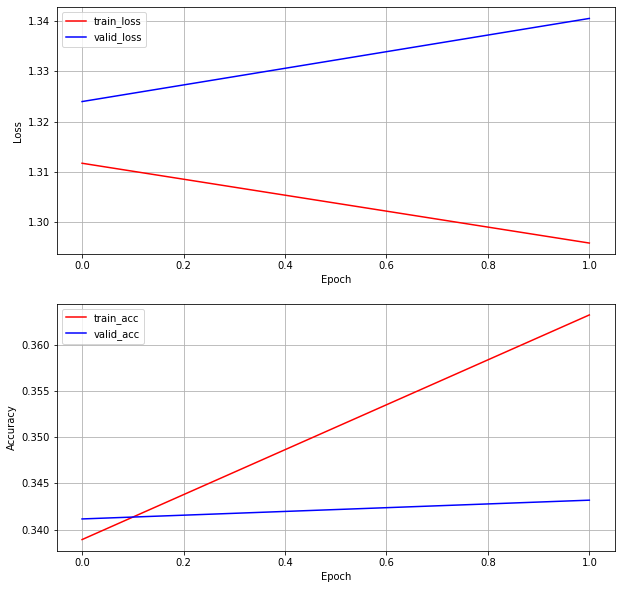

In [0]:
#GPUを使う場合
#dw = 50, dh = 10 epochs = 2
#最初はdw = 300とかでやっていたが、良くて1回しか学習しなかったため、ここまで減らした
#要　20000MiB以上のGPUパワー
dw = 50
dh = 10
max_size = 10

num_dict = len(list((get_counter_dict(X_train))))

#print(get_counter_dict(X_train))
print(num_dict)

class RNN(torch.nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        self.emb = torch.nn.Embedding(num_dict,dw)
        self.rnn = torch.nn.RNN(input_size = dw,
                                hidden_size = dh,
                                batch_first=False)
        self.linear = torch.nn.Linear(dh,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
        x = self.emb(x)
        y,h = self.rnn(x,h)
        y = y[:,-1,:]
        y = self.linear(y)
        return y
    
#要素が多すぎた場合は、その部分を削る必要がある。
#要素が足りなかった場合は、何かしらの方法でパッティングする必要がある
#その二つを解消する関数を作る

def Change_Tensor(X_df,size): #データフレームと、1行の要素のサイズを引数に指定
    vec_matrix = Change_id_df(X_df) #求めたい多次元配列
    id_dict = get_counter_dict(X_df) #X_dfの辞書
    Ans = []
    for vec in vec_matrix: #1行において
        if len(vec) > size: #sizeよりも大きかったら、そこに部分までを切り取り
            vec = vec[:size]
        else: #size以下なら、足りない分を中央値でパディング
            k = search_dict_median(id_dict)
            vec += [k] * (size - len(vec))
        Ans.append(vec)
    return torch.tensor(Ans,dtype=torch.int64)


def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k


#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = RNN()

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=8 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(2): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()
    
    t2 = time.time()
    print("今回のエポックの計算時間は" + str(t2-t1))
    
    #trainデータに対して
    Y_train_pred = model(X_train_torch.to(device)) #モデルに突っ込む
    loss_train = loss_fn(Y_train_pred, Y_train_torch.to(device)) #予想と実際のロスの計算
    train_loss.append(loss_train) #配列にappend
    acc_train  = accuracy(Y_train_pred, Y_train_torch.to(device)) #精度の計算
    train_acc.append(acc_train) #配列にappend
    
    #validデータに対して
    Y_valid_pred = model(X_valid_torch.to(device)) #モデルに突っ込む
    loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
    valid_loss.append(loss_valid) #配列にappend
    acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
    valid_acc.append(acc_valid) #配列にappend
    
    t3 = time.time()
    print("今回のロス・精度の計算時間は" + str(t3-t2))
    torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, train_loss, color="red", label="train_loss")
ax[0].plot(epochs, valid_loss, color="blue", label="valid_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, train_acc, color="red", label="train_acc")
ax[1].plot(epochs, valid_acc, color="blue", label="valid_acc")
ax[1].legend(loc=0)

plt.show()

121502
今回のエポックの計算時間は112.38778591156006
今回のロス・精度の計算時間は5.276554107666016
今回のエポックの計算時間は70.45806050300598
今回のロス・精度の計算時間は5.145751476287842
今回のエポックの計算時間は70.27205300331116
今回のロス・精度の計算時間は5.108759164810181
今回のエポックの計算時間は70.92020273208618
今回のロス・精度の計算時間は5.116990804672241
今回のエポックの計算時間は70.24027252197266
今回のロス・精度の計算時間は5.113582372665405


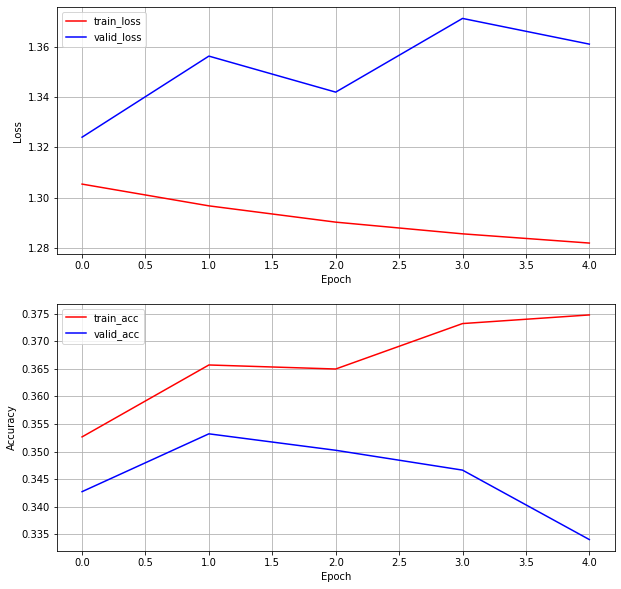

In [0]:
#GPUを使う場合
#dw = 30, dh = 10 epochs = 5
#最初はdw = 300とかでやっていたが、良くて1回しか学習しなかったため、ここまで減らした
#要　20000MiB以上のGPUパワー

dw = 30
dh = 10
max_size = 10

num_dict = len(list((get_counter_dict(X_train))))

#print(get_counter_dict(X_train))
print(num_dict)

class RNN(torch.nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        self.emb = torch.nn.Embedding(num_dict,dw)
        self.rnn = torch.nn.RNN(input_size = dw,
                                hidden_size = dh,
                                batch_first=False)
        self.linear = torch.nn.Linear(dh,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
        x = self.emb(x)
        y,h = self.rnn(x,h)
        y = y[:,-1,:]
        y = self.linear(y)
        return y
    
#要素が多すぎた場合は、その部分を削る必要がある。
#要素が足りなかった場合は、何かしらの方法でパッティングする必要がある
#その二つを解消する関数を作る

def Change_Tensor(X_df,size): #データフレームと、1行の要素のサイズを引数に指定
    vec_matrix = Change_id_df(X_df) #求めたい多次元配列
    id_dict = get_counter_dict(X_df) #X_dfの辞書
    Ans = []
    for vec in vec_matrix: #1行において
        if len(vec) > size: #sizeよりも大きかったら、そこに部分までを切り取り
            vec = vec[:size]
        else: #size以下なら、足りない分を中央値でパディング
            k = search_dict_median(id_dict)
            vec += [k] * (size - len(vec))
        Ans.append(vec)
    return torch.tensor(Ans,dtype=torch.int64)


def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k


#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = RNN()

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=8 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(5): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()
    
    t2 = time.time()
    print("今回のエポックの計算時間は" + str(t2-t1))
    
    #trainデータに対して
    Y_train_pred = model(X_train_torch.to(device)) #モデルに突っ込む
    loss_train = loss_fn(Y_train_pred, Y_train_torch.to(device)) #予想と実際のロスの計算
    train_loss.append(loss_train) #配列にappend
    acc_train  = accuracy(Y_train_pred, Y_train_torch.to(device)) #精度の計算
    train_acc.append(acc_train) #配列にappend
    
    #validデータに対して
    Y_valid_pred = model(X_valid_torch.to(device)) #モデルに突っ込む
    loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
    valid_loss.append(loss_valid) #配列にappend
    acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
    valid_acc.append(acc_valid) #配列にappend
    
    t3 = time.time()
    print("今回のロス・精度の計算時間は" + str(t3-t2))
    torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, train_loss, color="red", label="train_loss")
ax[0].plot(epochs, valid_loss, color="blue", label="valid_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, train_acc, color="red", label="train_acc")
ax[1].plot(epochs, valid_acc, color="blue", label="valid_acc")
ax[1].legend(loc=0)

plt.show()

In [0]:
X_train_torch = torch.load("Part9_Result/X_train_torch.pt")
Y_train_torch = torch.load("Part9_Result/Y_train_torch.pt")

X_valid_torch = torch.load("Part9_Result/X_valid_torch.pt")
Y_valid_torch = torch.load("Part9_Result/Y_valid_torch.pt")

X_test_torch = torch.load("Part9_Result/X_test_torch.pt")
Y_test_torch = torch.load("Part9_Result/Y_test_torch.pt")

121502
今回のエポックの計算時間は77.08584141731262
今回のロス・精度の計算時間は6.621226072311401
今回のエポックの計算時間は75.06475305557251
今回のロス・精度の計算時間は6.254772424697876
今回のエポックの計算時間は74.63655853271484
今回のロス・精度の計算時間は6.369123220443726
今回のエポックの計算時間は74.69607257843018
今回のロス・精度の計算時間は6.15002703666687
今回のエポックの計算時間は75.91671657562256
今回のロス・精度の計算時間は6.216875076293945
今回のエポックの計算時間は74.19620752334595
今回のロス・精度の計算時間は6.198336601257324
今回のエポックの計算時間は73.9967908859253
今回のロス・精度の計算時間は6.097939491271973
今回のエポックの計算時間は73.80551218986511
今回のロス・精度の計算時間は6.297165870666504
今回のエポックの計算時間は74.94604706764221
今回のロス・精度の計算時間は6.109671115875244
今回のエポックの計算時間は74.50198984146118
今回のロス・精度の計算時間は6.262897729873657
今回のエポックの計算時間は74.55146193504333
今回のロス・精度の計算時間は6.218893051147461
今回のエポックの計算時間は75.26473641395569
今回のロス・精度の計算時間は6.5002288818359375
今回のエポックの計算時間は74.84295964241028
今回のロス・精度の計算時間は6.398810863494873
今回のエポックの計算時間は74.36777997016907
今回のロス・精度の計算時間は6.187879323959351
今回のエポックの計算時間は74.30408930778503
今回のロス・精度の計算時間は6.176812171936035


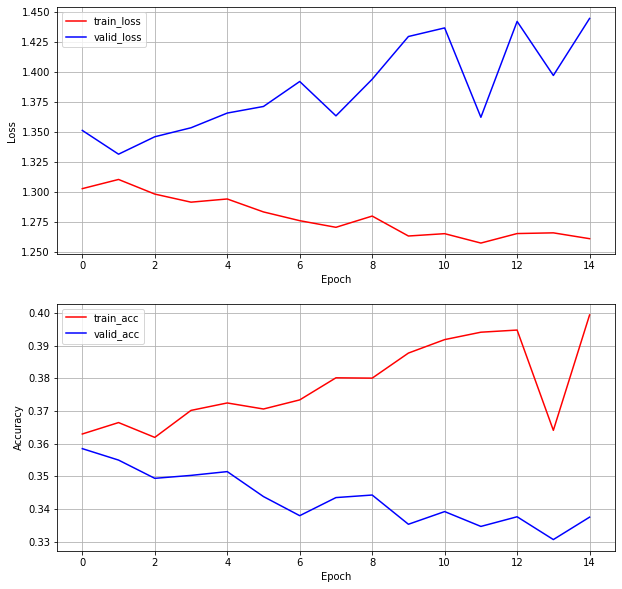

In [0]:
#GPUを使う場合
#dw = 20, dh = 5 epochs = 15
#最初はdw = 300とかでやっていたが、良くて1回しか学習しなかったため、ここまで減らした
#要　20000MiB以上のGPUパワー
dw = 20
dh = 5
max_size = 10

num_dict = len(list((get_counter_dict(X_train))))

#print(get_counter_dict(X_train))
print(num_dict)

class RNN(torch.nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        self.emb = torch.nn.Embedding(num_dict,dw)
        self.rnn = torch.nn.RNN(input_size = dw,
                                hidden_size = dh,
                                batch_first=False)
        self.linear = torch.nn.Linear(dh,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
        x = self.emb(x)
        y,h = self.rnn(x,h)
        y = y[:,-1,:]
        y = self.linear(y)
        return y
    
#要素が多すぎた場合は、その部分を削る必要がある。
#要素が足りなかった場合は、何かしらの方法でパッティングする必要がある
#その二つを解消する関数を作る

def Change_Tensor(X_df,size): #データフレームと、1行の要素のサイズを引数に指定
    vec_matrix = Change_id_df(X_df) #求めたい多次元配列
    id_dict = get_counter_dict(X_df) #X_dfの辞書
    Ans = []
    for vec in vec_matrix: #1行において
        if len(vec) > size: #sizeよりも大きかったら、そこに部分までを切り取り
            vec = vec[:size]
        else: #size以下なら、足りない分を中央値でパディング
            k = search_dict_median(id_dict)
            vec += [k] * (size - len(vec))
        Ans.append(vec)
    return torch.tensor(Ans,dtype=torch.int64)


def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k


#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = RNN()

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=8 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(15): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()
    
    t2 = time.time()
    print("今回のエポックの計算時間は" + str(t2-t1))
    
    #trainデータに対して
    Y_train_pred = model(X_train_torch.to(device)) #モデルに突っ込む
    loss_train = loss_fn(Y_train_pred, Y_train_torch.to(device)) #予想と実際のロスの計算
    train_loss.append(loss_train) #配列にappend
    acc_train  = accuracy(Y_train_pred, Y_train_torch.to(device)) #精度の計算
    train_acc.append(acc_train) #配列にappend
    
    #validデータに対して
    Y_valid_pred = model(X_valid_torch.to(device)) #モデルに突っ込む
    loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
    valid_loss.append(loss_valid) #配列にappend
    acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
    valid_acc.append(acc_valid) #配列にappend
    
    t3 = time.time()
    print("今回のロス・精度の計算時間は" + str(t3-t2))
    torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, train_loss, color="red", label="train_loss")
ax[0].plot(epochs, valid_loss, color="blue", label="valid_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, train_acc, color="red", label="train_acc")
ax[1].plot(epochs, valid_acc, color="blue", label="valid_acc")
ax[1].legend(loc=0)

plt.show()

In [0]:
!nvidia-smi

Sat May 30 17:04:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    32W /  70W |   8177MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#GPUを使う場合
#dw = 20, dh = 5 epochs = 15
#最初はdw = 300とかでやっていたが、良くて1回しか学習しなかったため、ここまで減らした
#要　20000MiB以上のGPUパワー
dw = 60
dh = 10
max_size = 10

num_dict = len(list((get_counter_dict(X_train))))

#print(get_counter_dict(X_train))
print(num_dict)

class RNN(torch.nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        self.emb = torch.nn.Embedding(num_dict,dw)
        self.rnn = torch.nn.RNN(input_size = dw,
                                hidden_size = dh,
                                batch_first=False)
        self.linear = torch.nn.Linear(dh,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
        x = self.emb(x)
        y,h = self.rnn(x,h)
        y = y[:,-1,:]
        y = self.linear(y)
        return y
    
#要素が多すぎた場合は、その部分を削る必要がある。
#要素が足りなかった場合は、何かしらの方法でパッティングする必要がある
#その二つを解消する関数を作る

def Change_Tensor(X_df,size): #データフレームと、1行の要素のサイズを引数に指定
    vec_matrix = Change_id_df(X_df) #求めたい多次元配列
    id_dict = get_counter_dict(X_df) #X_dfの辞書
    Ans = []
    for vec in vec_matrix: #1行において
        if len(vec) > size: #sizeよりも大きかったら、そこに部分までを切り取り
            vec = vec[:size]
        else: #size以下なら、足りない分を中央値でパディング
            k = search_dict_median(id_dict)
            vec += [k] * (size - len(vec))
        Ans.append(vec)
    return torch.tensor(Ans,dtype=torch.int64)


def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k


#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = RNN()

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=8 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(10): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()
    
    t2 = time.time()
    print("今回のエポックの計算時間は" + str(t2-t1))
    
    #trainデータに対して
    Y_train_pred = model(X_train_torch.to(device)) #モデルに突っ込む
    loss_train = loss_fn(Y_train_pred, Y_train_torch.to(device)) #予想と実際のロスの計算
    train_loss.append(loss_train) #配列にappend
    acc_train  = accuracy(Y_train_pred, Y_train_torch.to(device)) #精度の計算
    train_acc.append(acc_train) #配列にappend
    
    #validデータに対して
    Y_valid_pred = model(X_valid_torch.to(device)) #モデルに突っ込む
    loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
    valid_loss.append(loss_valid) #配列にappend
    acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
    valid_acc.append(acc_valid) #配列にappend
    
    t3 = time.time()
    print("今回のロス・精度の計算時間は" + str(t3-t2))
    torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, train_loss, color="red", label="train_loss")
ax[0].plot(epochs, valid_loss, color="blue", label="valid_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, train_acc, color="red", label="train_acc")
ax[1].plot(epochs, valid_acc, color="blue", label="valid_acc")
ax[1].legend(loc=0)

plt.show()

121502
今回のエポックの計算時間は95.7411572933197
今回のロス・精度の計算時間は5.119607210159302
今回のエポックの計算時間は72.98973083496094
今回のロス・精度の計算時間は5.527997732162476
今回のエポックの計算時間は74.90849280357361
今回のロス・精度の計算時間は5.098514795303345
今回のエポックの計算時間は72.88414406776428
今回のロス・精度の計算時間は5.06003999710083
今回のエポックの計算時間は73.04506063461304
今回のロス・精度の計算時間は5.122426986694336
今回のエポックの計算時間は72.59613919258118
今回のロス・精度の計算時間は4.995553970336914
今回のエポックの計算時間は73.2538731098175
今回のロス・精度の計算時間は5.007528066635132
今回のエポックの計算時間は72.23271012306213
今回のロス・精度の計算時間は5.132391929626465
今回のエポックの計算時間は72.53028178215027
今回のロス・精度の計算時間は5.039805173873901
今回のエポックの計算時間は71.86001420021057


RuntimeError: ignored

## 第83問

In [0]:
#Google Colabでデータの読み込みを行うときに必要なもの
#最初は以下に飛ばされるので、適宜自分の作業ディレクトリに移動
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/言語処理100本Knocks")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#GPUを止めると、毎回関数等を読み込まなくてはいけないので、必要な関数・ライブラリを一つのファイルにまとめる。
#(第80問を関数で実装したため、200行近くあり、張り付けると見にくい)
#%matplotlibは、マジックコマンドなのでこのファイルには入れられなかった。
#ので、別途実行

#以下を実行すると、変換したtensor行列(X_train_torch, Y_train_torch, X_valid_torch, Y_valid_torch, X_test_torch, Y_test_torch)が得られる
%run -i usual_Part9.py
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:174: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  safe_execfile(fname,*where,**kw)


In [0]:
print(type(X_train_torch_Pull_b))
for i,text in enumerate(Y_train_torch_Pull_b):
  if i == 5:
    break
  else:
    print(text)

<class 'torch.Tensor'>
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


121502
今回のエポックの計算時間は20.140371561050415
今回のロス・精度の計算時間は1.302582025527954
今回のエポックの計算時間は20.255650758743286
今回のロス・精度の計算時間は1.303406000137329
今回のエポックの計算時間は20.105175256729126
今回のロス・精度の計算時間は1.2954585552215576
今回のエポックの計算時間は23.656676769256592
今回のロス・精度の計算時間は1.2904245853424072
今回のエポックの計算時間は20.672328233718872
今回のロス・精度の計算時間は1.3344027996063232
今回のエポックの計算時間は19.97532820701599
今回のロス・精度の計算時間は1.3081011772155762
今回のエポックの計算時間は19.963244676589966
今回のロス・精度の計算時間は1.3072528839111328
今回のエポックの計算時間は20.074265718460083
今回のロス・精度の計算時間は1.3041203022003174
今回のエポックの計算時間は20.14778709411621
今回のロス・精度の計算時間は1.294844150543213
今回のエポックの計算時間は20.125632524490356
今回のロス・精度の計算時間は1.288172960281372
今回のエポックの計算時間は20.067415475845337
今回のロス・精度の計算時間は1.3037078380584717
今回のエポックの計算時間は20.06087350845337
今回のロス・精度の計算時間は1.3315799236297607
今回のエポックの計算時間は20.32282066345215
今回のロス・精度の計算時間は1.2966389656066895
今回のエポックの計算時間は20.05649471282959
今回のロス・精度の計算時間は1.2801785469055176
今回のエポックの計算時間は19.979674577713013
今回のロス・精度の計算時間は1.2870500087738037


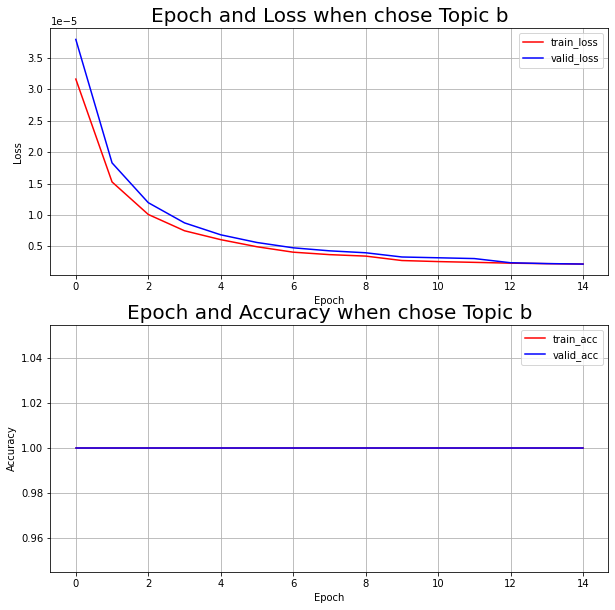

In [0]:
#GPUを使う場合
#dw = 30, dh = 10 epochs = 5
#最初はdw = 300とかでやっていたが、良くて1回しか学習しなかったため、ここまで減らした
#要　20000MiB以上のGPUパワー

#ファイルusual_Part9内に新しい関数を定義し、指定した記事番号のデータのみ抽出してTensor化

dw = 30
dh = 10
max_size = 10

num_dict = len(list((get_counter_dict(X_train))))

#print(get_counter_dict(X_train))
print(num_dict)

class RNN(torch.nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        self.emb = torch.nn.Embedding(num_dict,dw)
        self.rnn = torch.nn.RNN(input_size = dw,
                                hidden_size = dh,
                                batch_first=False)
        self.linear = torch.nn.Linear(dh,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
        x = self.emb(x)
        y,h = self.rnn(x,h)
        y = y[:,-1,:]
        y = self.linear(y)
        return y
    

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k


#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = RNN()

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch_Pull_b.to(device), Y_train_torch_Pull_b.to(device))
Loader = DataLoader(DataSet,batch_size=8 , shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(15): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()
    
    t2 = time.time()
    print("今回のエポックの計算時間は" + str(t2-t1))
    
    #trainデータに対して
    Y_train_pred = model(X_train_torch_Pull_b.to(device)) #モデルに突っ込む
    loss_train = loss_fn(Y_train_pred, Y_train_torch_Pull_b.to(device)) #予想と実際のロスの計算
    train_loss.append(loss_train) #配列にappend
    acc_train  = accuracy(Y_train_pred, Y_train_torch_Pull_b.to(device)) #精度の計算
    train_acc.append(acc_train) #配列にappend
    
    #validデータに対して
    Y_valid_pred = model(X_valid_torch_Pull_b.to(device)) #モデルに突っ込む
    loss_valid = loss_fn(Y_valid_pred, Y_valid_torch_Pull_b.to(device)) #予想と実際のロスの計算
    valid_loss.append(loss_valid) #配列にappend
    acc_valid  = accuracy(Y_valid_pred, Y_valid_torch_Pull_b.to(device)) #精度の計算
    valid_acc.append(acc_valid) #配列にappend
    
    t3 = time.time()
    print("今回のロス・精度の計算時間は" + str(t3-t2))
    torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_title("Epoch and Loss when chose Topic b",fontsize=20)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, train_loss, color="red", label="train_loss")
ax[0].plot(epochs, valid_loss, color="blue", label="valid_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_title("Epoch and Accuracy when chose Topic b",fontsize=20)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, train_acc, color="red", label="train_acc")
ax[1].plot(epochs, valid_acc, color="blue", label="valid_acc")
ax[1].legend(loc=0)

plt.show()

In [0]:
!nvidia-smi

Sun May 31 10:53:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## 第84問

In [0]:
#Google Colabでデータの読み込みを行うときに必要なもの
#最初は以下に飛ばされるので、適宜自分の作業ディレクトリに移動
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/言語処理100本Knocks")

#GPUを止めると、毎回関数等を読み込まなくてはいけないので、必要な関数・ライブラリを一つのファイルにまとめる。
#(第80問を関数で実装したため、200行近くあり、張り付けると見にくい)
#%matplotlibは、マジックコマンドなのでこのファイルには入れられなかった。
#ので、別途実行

#以下を実行すると、変換したtensor行列(X_train_torch, Y_train_torch, X_valid_torch, Y_valid_torch, X_test_torch, Y_test_torch)が得られる
%run -i usual_Part9.py
%matplotlib inline

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:174: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  safe_execfile(fname,*where,**kw)


In [0]:
!nvidia-smi

Wed Jun  3 04:29:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


今回のエポックの計算時間は43.039910554885864
今回のロス・精度の計算時間は0.0606076717376709
今回のエポックの計算時間は42.76204061508179
今回のロス・精度の計算時間は0.05700063705444336
今回のエポックの計算時間は43.333555936813354
今回のロス・精度の計算時間は0.05965256690979004
今回のエポックの計算時間は43.30715036392212
今回のロス・精度の計算時間は0.057932376861572266
今回のエポックの計算時間は43.73516321182251
今回のロス・精度の計算時間は0.057769060134887695


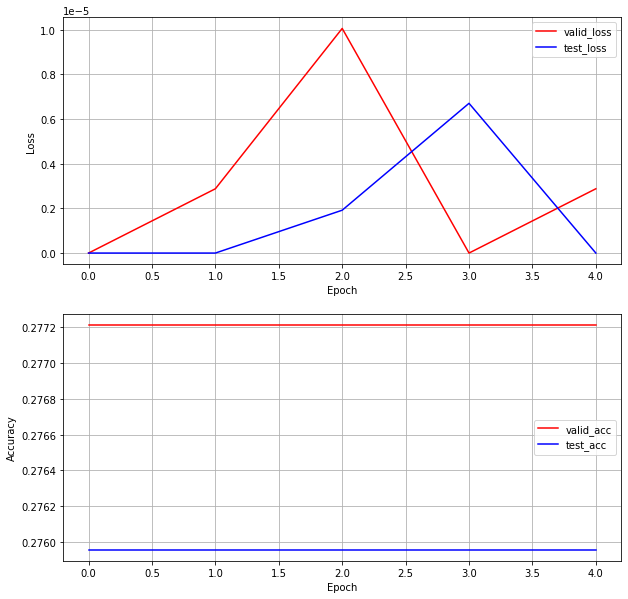

In [0]:
#GPUを使う場合
#最初はdw = 300とかでやっていたが、良くて1回しか学習しなかったため、ここまで減らした
#要　20000MiB以上のGPUパワー

#ここから、評価をvalidとtestで行うこととし、
#GPU負荷を下げる(いろいろ試したけど、最低130GiBは必要らしい...(GeForce RTX2080Ti × 13台くらい))
#trainはtensor的にデータ量が多いので、model()読み込み時にパンクしてしまう

dw = 300
dh = 10
max_size = 10

#num_dict = len(list((get_counter_dict(X_train))))

#print(get_counter_dict(X_train))
#print(num_dict)

class RNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        model = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary="True")
        weights = torch.FloatTensor(model.vectors)
        self.emb = torch.nn.Embedding.from_pretrained(weights)
        self.rnn = torch.nn.RNN(dw,dh,batch_first = True)
        self.linear = torch.nn.Linear(dh,1)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
        x = self.emb(x)
        y,h = self.rnn(x,h)
        y = y[:,-1,:]
        y = self.linear(y)
        return y

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k

#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = RNN()

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=16 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
valid_loss = []
valid_acc = []
test_loss = []
test_acc = []

for epoch in range(5): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()

    t2 = time.time()
    print("今回のエポックの計算時間は" + str(t2-t1))
    
    with torch.no_grad(): #こうしないと、メモリがパンクする

      #validデータに対して
      Y_valid_pred = model(X_valid_torch.to(device)) #モデルに突っ込む
      loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
      valid_loss.append(float(loss_valid)) #配列にappend
      acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
      valid_acc.append(acc_valid) #配列にappend

      #testデータに対して
      Y_test_pred = model(X_test_torch.to(device)) #モデルに突っ込む
      loss_test = loss_fn(Y_test_pred, Y_test_torch.to(device)) #予想と実際のロスの計算
      test_loss.append(float(loss_test)) #配列にappend
      acc_test  = accuracy(Y_test_pred, Y_test_torch.to(device)) #精度の計算
      test_acc.append(acc_test) #配列にappend
    
      t3 = time.time()
      print("今回のロス・精度の計算時間は" + str(t3-t2))
      torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, valid_loss, color="red", label="valid_loss")
ax[0].plot(epochs, test_loss, color="blue", label="test_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, valid_acc, color="red", label="valid_acc")
ax[1].plot(epochs, test_acc, color="blue", label="test_acc")
ax[1].legend(loc=0)

plt.show()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


今回のエポックの計算時間は44.040198802948
今回のロス・精度の計算時間は0.19687438011169434
今回のエポックの計算時間は44.37398433685303
今回のロス・精度の計算時間は0.17666411399841309
今回のエポックの計算時間は43.356921911239624
今回のロス・精度の計算時間は0.1871626377105713
今回のエポックの計算時間は42.55429816246033
今回のロス・精度の計算時間は0.19024944305419922
今回のエポックの計算時間は44.236472368240356
今回のロス・精度の計算時間は0.17633724212646484
今回のエポックの計算時間は42.898107051849365
今回のロス・精度の計算時間は0.17281246185302734
今回のエポックの計算時間は42.65224599838257
今回のロス・精度の計算時間は0.17206597328186035
今回のエポックの計算時間は43.083455085754395
今回のロス・精度の計算時間は0.18479180335998535
今回のエポックの計算時間は42.680187463760376
今回のロス・精度の計算時間は0.19248175621032715
今回のエポックの計算時間は43.64468598365784
今回のロス・精度の計算時間は0.19504117965698242


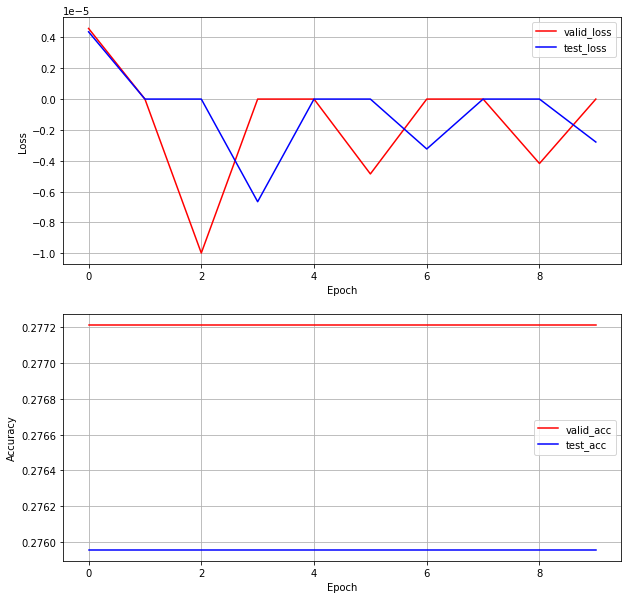

In [0]:
#GPUを使う場合
#最初はdw = 300とかでやっていたが、良くて1回しか学習しなかったため、ここまで減らした
#要　20000MiB以上のGPUパワー

#ここから、評価をvalidとtestで行うこととし、
#GPU負荷を下げる(いろいろ試したけど、最低130GiBは必要らしい...(GeForce RTX2080Ti × 13台くらい))

#今度はdhを増やす⇒？GPU使用量は変わらない？

dw = 300
dh = 300
max_size = 10

#num_dict = len(list((get_counter_dict(X_train))))

#print(get_counter_dict(X_train))
#print(num_dict)

class RNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        model = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary="True")
        weights = torch.FloatTensor(model.vectors)
        self.emb = torch.nn.Embedding.from_pretrained(weights)
        self.rnn = torch.nn.RNN(dw,dh,batch_first = True)
        self.linear = torch.nn.Linear(dh,1)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
        x = self.emb(x)
        y,h = self.rnn(x,h)
        y = y[:,-1,:]
        y = self.linear(y)
        return y

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k

#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = RNN()

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=16 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
valid_loss = []
valid_acc = []
test_loss = []
test_acc = []

for epoch in range(10): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()

    t2 = time.time()
    print("今回のエポックの計算時間は" + str(t2-t1))
    
    with torch.no_grad(): #こうしないと、メモリがパンクする

      #validデータに対して
      Y_valid_pred = model(X_valid_torch.to(device)) #モデルに突っ込む
      loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
      valid_loss.append(float(loss_valid)) #配列にappend
      acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
      valid_acc.append(acc_valid) #配列にappend

      #testデータに対して
      Y_test_pred = model(X_test_torch.to(device)) #モデルに突っ込む
      loss_test = loss_fn(Y_test_pred, Y_test_torch.to(device)) #予想と実際のロスの計算
      test_loss.append(float(loss_test)) #配列にappend
      acc_test  = accuracy(Y_test_pred, Y_test_torch.to(device)) #精度の計算
      test_acc.append(acc_test) #配列にappend
    
      t3 = time.time()
      print("今回のロス・精度の計算時間は" + str(t3-t2))
      torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, valid_loss, color="red", label="valid_loss")
ax[0].plot(epochs, test_loss, color="blue", label="test_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, valid_acc, color="red", label="valid_acc")
ax[1].plot(epochs, test_acc, color="blue", label="test_acc")
ax[1].legend(loc=0)

plt.show()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


今回のエポックの計算時間は4.929312229156494
今回のロス・精度の計算時間は0.18465805053710938
今回のエポックの計算時間は4.849920272827148
今回のロス・精度の計算時間は0.18102049827575684
今回のエポックの計算時間は5.311742544174194
今回のロス・精度の計算時間は0.18167567253112793
今回のエポックの計算時間は5.2047178745269775
今回のロス・精度の計算時間は0.18989944458007812
今回のエポックの計算時間は5.157951593399048
今回のロス・精度の計算時間は0.18168139457702637
今回のエポックの計算時間は5.275330543518066
今回のロス・精度の計算時間は0.18197965621948242
今回のエポックの計算時間は5.518451929092407
今回のロス・精度の計算時間は0.1833200454711914
今回のエポックの計算時間は5.357219696044922
今回のロス・精度の計算時間は0.18320679664611816
今回のエポックの計算時間は5.3339245319366455
今回のロス・精度の計算時間は0.18121981620788574
今回のエポックの計算時間は5.219071388244629
今回のロス・精度の計算時間は0.17908072471618652


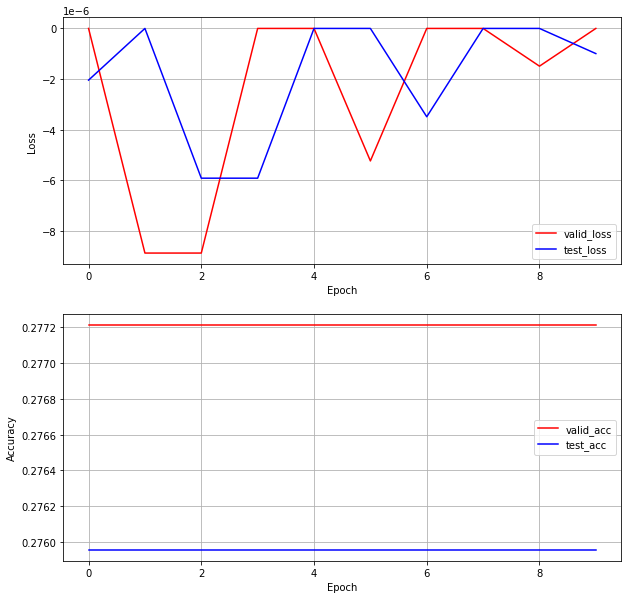

In [0]:
#GPUを使う場合
#最初はdw = 300とかでやっていたが、良くて1回しか学習しなかったため、ここまで減らした
#要　20000MiB以上のGPUパワー

#ここから、評価をvalidとtestで行うこととし、
#GPU負荷を下げる(いろいろ試したけど、最低130GiBは必要らしい...(GeForce RTX2080Ti × 13台くらい))

#今度はバッチサイズを増やす⇒？GPU使用量は変わらない？

dw = 300
dh = 300
max_size = 10

#num_dict = len(list((get_counter_dict(X_train))))

#print(get_counter_dict(X_train))
#print(num_dict)

class RNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        model = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary="True")
        weights = torch.FloatTensor(model.vectors)
        self.emb = torch.nn.Embedding.from_pretrained(weights)
        self.rnn = torch.nn.RNN(dw,dh,batch_first = True)
        self.linear = torch.nn.Linear(dh,1)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
        x = self.emb(x)
        y,h = self.rnn(x,h)
        y = y[:,-1,:]
        y = self.linear(y)
        return y

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k

#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = RNN()

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=1024 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
valid_loss = []
valid_acc = []
test_loss = []
test_acc = []

for epoch in range(10): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()

    t2 = time.time()
    print("今回のエポックの計算時間は" + str(t2-t1))
    
    with torch.no_grad(): #こうしないと、メモリがパンクする

      #validデータに対して
      Y_valid_pred = model(X_valid_torch.to(device)) #モデルに突っ込む
      loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
      valid_loss.append(float(loss_valid)) #配列にappend
      acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
      valid_acc.append(acc_valid) #配列にappend

      #testデータに対して
      Y_test_pred = model(X_test_torch.to(device)) #モデルに突っ込む
      loss_test = loss_fn(Y_test_pred, Y_test_torch.to(device)) #予想と実際のロスの計算
      test_loss.append(float(loss_test)) #配列にappend
      acc_test  = accuracy(Y_test_pred, Y_test_torch.to(device)) #精度の計算
      test_acc.append(acc_test) #配列にappend
    
      t3 = time.time()
      print("今回のロス・精度の計算時間は" + str(t3-t2))
      torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, valid_loss, color="red", label="valid_loss")
ax[0].plot(epochs, test_loss, color="blue", label="test_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, valid_acc, color="red", label="valid_acc")
ax[1].plot(epochs, test_acc, color="blue", label="test_acc")
ax[1].legend(loc=0)

plt.show()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


今回のエポックの計算時間は4.9134521484375
今回のロス・精度の計算時間は0.1445009708404541
今回のエポックの計算時間は5.73009729385376
今回のロス・精度の計算時間は0.14657878875732422
今回のエポックの計算時間は5.767704248428345
今回のロス・精度の計算時間は0.14540982246398926
今回のエポックの計算時間は5.660860538482666
今回のロス・精度の計算時間は0.14784574508666992
今回のエポックの計算時間は5.641080141067505
今回のロス・精度の計算時間は0.14891290664672852
今回のエポックの計算時間は6.101840496063232
今回のロス・精度の計算時間は0.14601969718933105
今回のエポックの計算時間は5.680962800979614
今回のロス・精度の計算時間は0.1502819061279297
今回のエポックの計算時間は5.68002462387085
今回のロス・精度の計算時間は0.15401577949523926
今回のエポックの計算時間は5.733006954193115
今回のロス・精度の計算時間は0.14321279525756836
今回のエポックの計算時間は5.734083414077759
今回のロス・精度の計算時間は0.15178823471069336
今回のエポックの計算時間は5.774193048477173
今回のロス・精度の計算時間は0.1485152244567871
今回のエポックの計算時間は5.868707180023193
今回のロス・精度の計算時間は0.14821839332580566
今回のエポックの計算時間は5.789055109024048
今回のロス・精度の計算時間は0.1476438045501709
今回のエポックの計算時間は5.727889060974121
今回のロス・精度の計算時間は0.14745068550109863
今回のエポックの計算時間は5.907850980758667
今回のロス・精度の計算時間は0.14714336395263672
今回のエポックの計算時間は5.964952707290649
今回

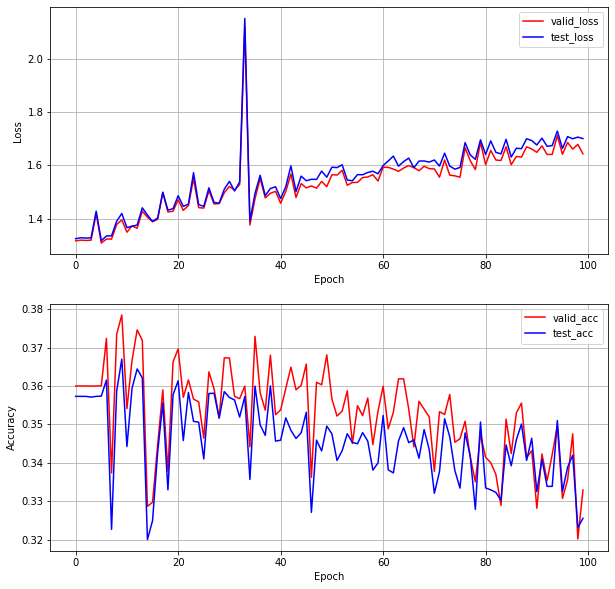

In [0]:
#GPUを使う場合
#最初はdw = 300とかでやっていたが、良くて1回しか学習しなかったため、ここまで減らした
#要　20000MiB以上のGPUパワー

#ここから、評価をvalidとtestで行うこととし、
#GPU負荷を下げる(いろいろ試したけど、最低130GiBは必要らしい...(GeForce RTX2080Ti × 13台くらい))

#今度はepoch数とバッチサイズをさらに上げる⇒？GPU使用量は変わらない？
#いろいろ戻しても見る

dw = 300
dh = 300
max_size = 10

#num_dict = len(list((get_counter_dict(X_train))))

#print(get_counter_dict(X_train))
#print(num_dict)

class RNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        model = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary="True")
        weights = torch.FloatTensor(model.vectors)
        self.emb = torch.nn.Embedding.from_pretrained(weights)
        self.rnn = torch.nn.RNN(dw,dh,batch_first = True)
        self.linear = torch.nn.Linear(dh,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
        x = self.emb(x)
        y,h = self.rnn(x,h)
        y = y[:,-1,:]
        y = self.linear(y)
        return y

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k

#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = RNN()

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=4096 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
valid_loss = []
valid_acc = []
test_loss = []
test_acc = []

for epoch in range(100): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()

    t2 = time.time()
    print("今回のエポックの計算時間は" + str(t2-t1))
    
    with torch.no_grad(): #こうしないと、メモリがパンクする

      #validデータに対して
      Y_valid_pred = model(X_valid_torch.to(device)) #モデルに突っ込む
      loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
      valid_loss.append(loss_valid) #配列にappend
      acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
      valid_acc.append(acc_valid) #配列にappend

      #testデータに対して
      Y_test_pred = model(X_test_torch.to(device)) #モデルに突っ込む
      loss_test = loss_fn(Y_test_pred, Y_test_torch.to(device)) #予想と実際のロスの計算
      test_loss.append(loss_test) #配列にappend
      acc_test  = accuracy(Y_test_pred, Y_test_torch.to(device)) #精度の計算
      test_acc.append(acc_test) #配列にappend
    
      t3 = time.time()
      print("今回のロス・精度の計算時間は" + str(t3-t2))
      torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, valid_loss, color="red", label="valid_loss")
ax[0].plot(epochs, test_loss, color="blue", label="test_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, valid_acc, color="red", label="valid_acc")
ax[1].plot(epochs, test_acc, color="blue", label="test_acc")
ax[1].legend(loc=0)

plt.show()

## 第85問

In [0]:
#Google Colabでデータの読み込みを行うときに必要なもの
#最初は以下に飛ばされるので、適宜自分の作業ディレクトリに移動
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/言語処理100本Knocks")

#GPUを止めると、毎回関数等を読み込まなくてはいけないので、必要な関数・ライブラリを一つのファイルにまとめる。
#(第80問を関数で実装したため、200行近くあり、張り付けると見にくい)
#%matplotlibは、マジックコマンドなのでこのファイルには入れられなかった。
#ので、別途実行

#以下を実行すると、変換したtensor行列(X_train_torch, Y_train_torch, X_valid_torch, Y_valid_torch, X_test_torch, Y_test_torch)が得られる
%run -i usual_Part9.py
%matplotlib inline

!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:174: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  safe_execfile(fname,*where,**kw)


Wed Jun  3 04:49:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


今回のエポックの計算時間は7.216113090515137
今回のロス・精度の計算時間は0.2859153747558594
今回のエポックの計算時間は7.152066469192505
今回のロス・精度の計算時間は0.2941317558288574
今回のエポックの計算時間は7.621830224990845
今回のロス・精度の計算時間は0.2875797748565674
今回のエポックの計算時間は7.876824617385864
今回のロス・精度の計算時間は0.28972315788269043
今回のエポックの計算時間は7.574291944503784
今回のロス・精度の計算時間は0.29047608375549316
今回のエポックの計算時間は7.741541385650635
今回のロス・精度の計算時間は0.29202938079833984
今回のエポックの計算時間は7.984949588775635
今回のロス・精度の計算時間は0.2889876365661621
今回のエポックの計算時間は7.571460485458374
今回のロス・精度の計算時間は0.2975015640258789
今回のエポックの計算時間は7.68569540977478
今回のロス・精度の計算時間は0.29111146926879883
今回のエポックの計算時間は7.987002611160278
今回のロス・精度の計算時間は0.30346202850341797
今回のエポックの計算時間は7.990553617477417
今回のロス・精度の計算時間は0.30791378021240234
今回のエポックの計算時間は7.462798595428467
今回のロス・精度の計算時間は0.30039501190185547
今回のエポックの計算時間は7.695353984832764
今回のロス・精度の計算時間は0.2931199073791504
今回のエポックの計算時間は7.895975351333618
今回のロス・精度の計算時間は0.2995455265045166
今回のエポックの計算時間は7.450210332870483
今回のロス・精度の計算時間は0.28968000411987305
今回のエポックの計算時間は7.80213475227356
今回の

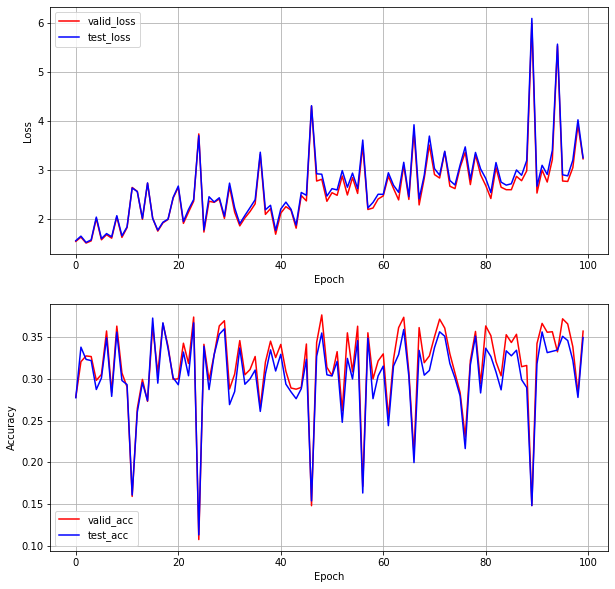

In [0]:
#GPUを使う場合
#最初はdw = 300とかでやっていたが、良くて1回しか学習しなかったため、ここまで減らした
#要　20000MiB以上のGPUパワー

#ここから、評価をvalidとtestで行うこととし、
#GPU負荷を下げる(いろいろ試したけど、最低130GiBは必要らしい...(GeForce RTX2080Ti × 13台くらい))

#今度はepoch数とバッチサイズをさらに上げる⇒？GPU使用量は変わらない？
#いろいろ戻しても見る

#bidirectional=Trueとするだけ
#ただし、逆と順方向とで2倍のdhが必要になるのでそこは改変
#面白そうなので、LSTMも組み合わせみる

dw = 300
dh = 50
max_size = 10

#num_dict = len(list((get_counter_dict(X_train))))

#print(get_counter_dict(X_train))
#print(num_dict)

class RNN(torch.nn.Module):
    def __init__(self,n_layer=2):
        super().__init__()
        model = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary="True")
        weights = torch.FloatTensor(model.vectors)
        self.emb = torch.nn.Embedding.from_pretrained(weights)
        self.rnn1 = torch.nn.RNN(dw,dh,n_layer,batch_first = True,bidirectional=True)
        self.rnn2 = torch.nn.RNN(2*dh,dh,n_layer,batch_first = True,bidirectional=True)
        self.rnn3 = torch.nn.RNN(2*dh,dh,n_layer,batch_first = True,bidirectional=True)
        #self.lstm1 = torch.nn.LSTM(2*dh,dh,n_layer,batch_first = True,bidirectional=True)
        #self.lstm2 = torch.nn.LSTM(2*dh,dh,n_layer,batch_first = True,bidirectional=True)
        self.linear = torch.nn.Linear(2*dh,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
        x = self.emb(x)
        y,h = self.rnn1(x,h)
        #y,h = self.lstm1(y,h)
        y,h = self.rnn2(y,h)
        #y,h = self.lstm2(y,h)
        y,h = self.rnn3(y,h)
        y = y[:,-1,:]
        y = self.linear(y)
        return y

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k

#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = RNN(n_layer=2)

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=1024 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
valid_loss = []
valid_acc = []
test_loss = []
test_acc = []

for epoch in range(100): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()

    t2 = time.time()
    print("今回のエポックの計算時間は" + str(t2-t1))
    
    with torch.no_grad(): #こうしないと、メモリがパンクする

      #validデータに対して
      Y_valid_pred = model(X_valid_torch.to(device)) #モデルに突っ込む
      loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
      valid_loss.append(loss_valid) #配列にappend
      acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
      valid_acc.append(acc_valid) #配列にappend

      #testデータに対して
      Y_test_pred = model(X_test_torch.to(device)) #モデルに突っ込む
      loss_test = loss_fn(Y_test_pred, Y_test_torch.to(device)) #予想と実際のロスの計算
      test_loss.append(loss_test) #配列にappend
      acc_test  = accuracy(Y_test_pred, Y_test_torch.to(device)) #精度の計算
      test_acc.append(acc_test) #配列にappend
    
      t3 = time.time()
      print("今回のロス・精度の計算時間は" + str(t3-t2))
      torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, valid_loss, color="red", label="valid_loss")
ax[0].plot(epochs, test_loss, color="blue", label="test_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, valid_acc, color="red", label="valid_acc")
ax[1].plot(epochs, test_acc, color="blue", label="test_acc")
ax[1].legend(loc=0)

plt.show()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


今回のエポックの計算時間は7.899623155593872
今回のロス・精度の計算時間は0.3617234230041504
今回のエポックの計算時間は8.417179822921753
今回のロス・精度の計算時間は0.3757925033569336
今回のエポックの計算時間は8.260732650756836
今回のロス・精度の計算時間は0.37123608589172363
今回のエポックの計算時間は8.18259882926941
今回のロス・精度の計算時間は0.39647960662841797
今回のエポックの計算時間は8.236084222793579
今回のロス・精度の計算時間は0.38300585746765137
今回のエポックの計算時間は8.489356517791748
今回のロス・精度の計算時間は0.39743995666503906
今回のエポックの計算時間は8.294576168060303
今回のロス・精度の計算時間は0.3672611713409424
今回のエポックの計算時間は8.109398365020752
今回のロス・精度の計算時間は0.38242340087890625
今回のエポックの計算時間は8.24812650680542
今回のロス・精度の計算時間は0.3774745464324951
今回のエポックの計算時間は8.239121437072754
今回のロス・精度の計算時間は0.3582346439361572
今回のエポックの計算時間は8.20755648612976
今回のロス・精度の計算時間は0.36933207511901855
今回のエポックの計算時間は8.162003517150879
今回のロス・精度の計算時間は0.37738895416259766
今回のエポックの計算時間は8.481359004974365
今回のロス・精度の計算時間は0.3709437847137451
今回のエポックの計算時間は8.076249599456787
今回のロス・精度の計算時間は0.36409497261047363
今回のエポックの計算時間は8.1849684715271
今回のロス・精度の計算時間は0.3868834972381592
今回のエポックの計算時間は8.323020696640015
今回のロス・

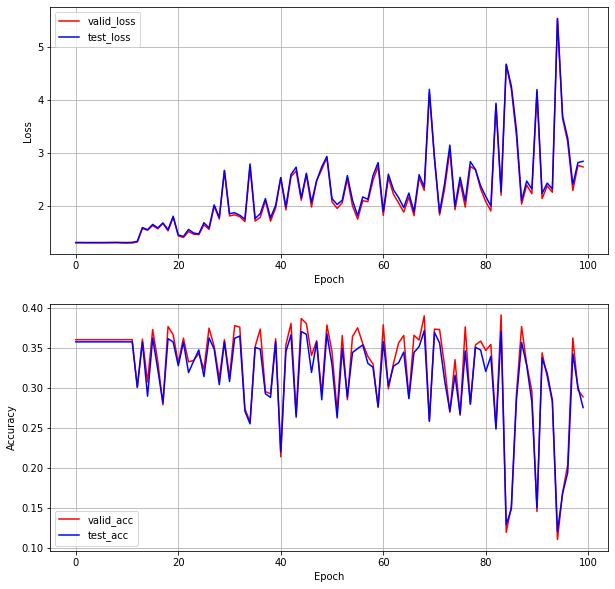

In [0]:
#GPUを使う場合
#最初はdw = 300とかでやっていたが、良くて1回しか学習しなかったため、ここまで減らした
#要　20000MiB以上のGPUパワー

#ここから、評価をvalidとtestで行うこととし、
#GPU負荷を下げる(いろいろ試したけど、最低130GiBは必要らしい...(GeForce RTX2080Ti × 13台くらい))

#今度はepoch数とバッチサイズをさらに上げる⇒？GPU使用量は変わらない？
#いろいろ戻しても見る

#bidirectional=Trueとするだけ
#ただし、逆と順方向とで2倍のdhが必要になるのでそこは改変
#面白そうなので、LSTMも組み合わせみる

dw = 300
dh = 50
max_size = 10

#num_dict = len(list((get_counter_dict(X_train))))

#print(get_counter_dict(X_train))
#print(num_dict)

class RNN(torch.nn.Module):
    def __init__(self,n_layer=2):
        super().__init__()
        model = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary="True")
        weights = torch.FloatTensor(model.vectors)
        self.emb = torch.nn.Embedding.from_pretrained(weights)
        #self.rnn1 = torch.nn.RNN(dw,dh,n_layer,batch_first = True,bidirectional=True)
        #self.rnn2 = torch.nn.RNN(2*dh,dh,n_layer,batch_first = True,bidirectional=True)
        #self.rnn3 = torch.nn.RNN(2*dh,dh,n_layer,batch_first = True,bidirectional=True)
        self.lstm1 = torch.nn.LSTM(dw,dh,n_layer,batch_first = True,bidirectional=True)
        self.lstm2 = torch.nn.LSTM(2*dh,dh,n_layer,batch_first = True,bidirectional=True)
        self.linear = torch.nn.Linear(2*dh,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
        x = self.emb(x)
        #y,h = self.rnn1(x,h)
        y,h = self.lstm1(x,h)
        #y,h = self.rnn2(y,h)
        y,h = self.lstm2(y,h)
        #y,h = self.rnn3(y,h)
        y = y[:,-1,:]
        y = self.linear(y)
        return y

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k

#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = RNN(n_layer=2)

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=1024 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
valid_loss = []
valid_acc = []
test_loss = []
test_acc = []

for epoch in range(100): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()

    t2 = time.time()
    print("今回のエポックの計算時間は" + str(t2-t1))
    
    with torch.no_grad(): #こうしないと、メモリがパンクする

      #validデータに対して
      Y_valid_pred = model(X_valid_torch.to(device)) #モデルに突っ込む
      loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
      valid_loss.append(loss_valid) #配列にappend
      acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
      valid_acc.append(acc_valid) #配列にappend

      #testデータに対して
      Y_test_pred = model(X_test_torch.to(device)) #モデルに突っ込む
      loss_test = loss_fn(Y_test_pred, Y_test_torch.to(device)) #予想と実際のロスの計算
      test_loss.append(loss_test) #配列にappend
      acc_test  = accuracy(Y_test_pred, Y_test_torch.to(device)) #精度の計算
      test_acc.append(acc_test) #配列にappend
    
      t3 = time.time()
      print("今回のロス・精度の計算時間は" + str(t3-t2))
      torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, valid_loss, color="red", label="valid_loss")
ax[0].plot(epochs, test_loss, color="blue", label="test_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, valid_acc, color="red", label="valid_acc")
ax[1].plot(epochs, test_acc, color="blue", label="test_acc")
ax[1].legend(loc=0)

plt.show()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


今回のエポックの計算時間は7.2107994556427
今回のロス・精度の計算時間は0.31070852279663086
今回のエポックの計算時間は7.853739261627197
今回のロス・精度の計算時間は0.2909729480743408
今回のエポックの計算時間は7.976786851882935
今回のロス・精度の計算時間は0.31761765480041504
今回のエポックの計算時間は8.152236223220825
今回のロス・精度の計算時間は0.3177785873413086
今回のエポックの計算時間は7.849212646484375
今回のロス・精度の計算時間は0.30164456367492676
今回のエポックの計算時間は8.225616693496704
今回のロス・精度の計算時間は0.2942771911621094
今回のエポックの計算時間は7.933649063110352
今回のロス・精度の計算時間は0.3018038272857666
今回のエポックの計算時間は7.71999454498291
今回のロス・精度の計算時間は0.2907743453979492
今回のエポックの計算時間は8.01773977279663
今回のロス・精度の計算時間は0.2883906364440918
今回のエポックの計算時間は7.947375059127808
今回のロス・精度の計算時間は0.29081249237060547
今回のエポックの計算時間は7.873065233230591
今回のロス・精度の計算時間は0.31452250480651855
今回のエポックの計算時間は8.23171615600586
今回のロス・精度の計算時間は0.2904942035675049
今回のエポックの計算時間は8.134456634521484
今回のロス・精度の計算時間は0.2940235137939453
今回のエポックの計算時間は7.780251741409302
今回のロス・精度の計算時間は0.30788636207580566
今回のエポックの計算時間は8.247989416122437
今回のロス・精度の計算時間は0.3053152561187744
今回のエポックの計算時間は8.116512775421143
今回のロス・精度

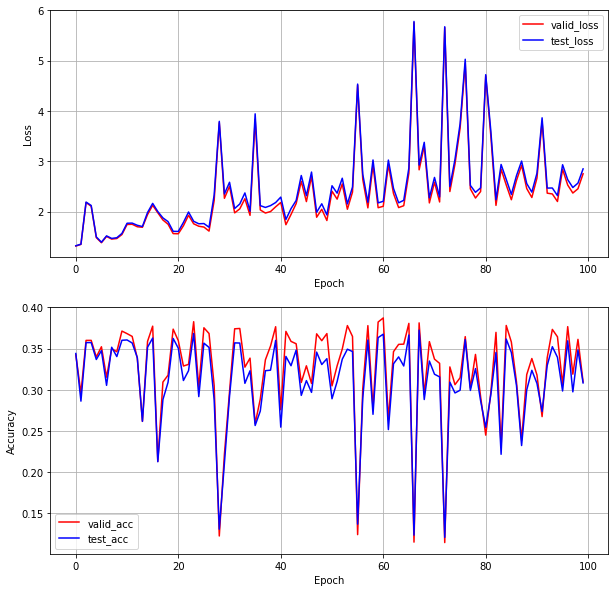

In [0]:
#GPUを使う場合
#最初はdw = 300とかでやっていたが、良くて1回しか学習しなかったため、ここまで減らした
#要　20000MiB以上のGPUパワー

#ここから、評価をvalidとtestで行うこととし、
#GPU負荷を下げる(いろいろ試したけど、最低130GiBは必要らしい...(GeForce RTX2080Ti × 13台くらい))

#今度はepoch数とバッチサイズをさらに上げる⇒？GPU使用量は変わらない？
#いろいろ戻しても見る

#bidirectional=Trueとするだけ
#ただし、逆と順方向とで2倍のdhが必要になるのでそこは改変
#面白そうなので、LSTMも組み合わせみる

dw = 300
dh = 50
max_size = 10

#num_dict = len(list((get_counter_dict(X_train))))

#print(get_counter_dict(X_train))
#print(num_dict)

class RNN(torch.nn.Module):
    def __init__(self,n_layer=2):
        super().__init__()
        model = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary="True")
        weights = torch.FloatTensor(model.vectors)
        self.emb = torch.nn.Embedding.from_pretrained(weights)
        #self.rnn1 = torch.nn.RNN(dw,dh,n_layer,batch_first = True,bidirectional=True)
        #self.rnn2 = torch.nn.RNN(2*dh,dh,n_layer,batch_first = True,bidirectional=True)
        #self.rnn3 = torch.nn.RNN(2*dh,dh,n_layer,batch_first = True,bidirectional=True)
        self.gru1 = torch.nn.GRU(dw,dh,n_layer,batch_first = True,bidirectional=True)
        self.gru2 = torch.nn.GRU(2*dh,dh,n_layer,batch_first = True,bidirectional=True)
        self.linear = torch.nn.Linear(2*dh,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
        x = self.emb(x)
        #y,h = self.rnn1(x,h)
        y,h = self.gru1(x,h)
        #y,h = self.rnn2(y,h)
        y,h = self.gru2(y,h)
        #y,h = self.rnn3(y,h)
        y = y[:,-1,:]
        y = self.linear(y)
        return y

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k

#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = RNN(n_layer=2)

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=1024 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
valid_loss = []
valid_acc = []
test_loss = []
test_acc = []

for epoch in range(100): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()

    t2 = time.time()
    print("今回のエポックの計算時間は" + str(t2-t1))
    
    with torch.no_grad(): #こうしないと、メモリがパンクする

      #validデータに対して
      Y_valid_pred = model(X_valid_torch.to(device)) #モデルに突っ込む
      loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
      valid_loss.append(loss_valid) #配列にappend
      acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
      valid_acc.append(acc_valid) #配列にappend

      #testデータに対して
      Y_test_pred = model(X_test_torch.to(device)) #モデルに突っ込む
      loss_test = loss_fn(Y_test_pred, Y_test_torch.to(device)) #予想と実際のロスの計算
      test_loss.append(loss_test) #配列にappend
      acc_test  = accuracy(Y_test_pred, Y_test_torch.to(device)) #精度の計算
      test_acc.append(acc_test) #配列にappend
    
      t3 = time.time()
      print("今回のロス・精度の計算時間は" + str(t3-t2))
      torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, valid_loss, color="red", label="valid_loss")
ax[0].plot(epochs, test_loss, color="blue", label="test_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, valid_acc, color="red", label="valid_acc")
ax[1].plot(epochs, test_acc, color="blue", label="test_acc")
ax[1].legend(loc=0)

plt.show()

## 第86問

In [0]:
#Google Colabでデータの読み込みを行うときに必要なもの
#最初は以下に飛ばされるので、適宜自分の作業ディレクトリに移動
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/言語処理100本Knocks")

#GPUを止めると、毎回関数等を読み込まなくてはいけないので、必要な関数・ライブラリを一つのファイルにまとめる。
#(第80問を関数で実装したため、200行近くあり、張り付けると見にくい)
#%matplotlibは、マジックコマンドなのでこのファイルには入れられなかった。
#ので、別途実行

#以下を実行すると、変換したtensor行列(X_train_torch, Y_train_torch, X_valid_torch, Y_valid_torch, X_test_torch, Y_test_torch)が得られる
%run -i usual_Part9.py
%matplotlib inline

!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:174: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  safe_execfile(fname,*where,**kw)


Fri Jun  5 06:53:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
dw = 300
dh = 50
max_size = 10

num_dict = len(list((get_counter_dict(X_train))))

#言語処理は1次元データなので、conv1dを使う
#画像処理系は、2次元データであるからconv2dを使って定義していく
#x.viewを入れないとどうなるのかが良くわからなかったので
#比較のために、x.viewを入れないとどうなるのかを試すことにする

class CNN1(torch.nn.Module):
    def __init__(self):
        super(CNN1,self).__init__()
        self.emb = torch.nn.Embedding(num_dict,dw)
        self.conv1d = torch.nn.Conv1d(in_channels = dw,
                                      out_channels = dh,
                                      kernel_size = 3,
                                      padding = 1)
        self.tanh = torch.nn.tanh()
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool1d(max_size)
        self.linear = torch.nn.Linear(dw,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
      #CNNの構造
      #x.sizeは(Batchsize,channel,Height,Width)のタプルを返す
        x = self.emb(x)
        x = self.conv1d(x)
        #x = self.tanh(x)
        x = self.relu(x)
        x = self.pool(x)
        y = self.linear(x)
        #y = self.softmax(y) #クロスエントロピーロス
        return y



class CNN2(torch.nn.Module):
    def __init__(self):
        super(CNN2,self).__init__()
        self.emb = torch.nn.Embedding(num_dict,dw)
        self.conv1d = torch.nn.Conv1d(in_channels = dw,
                                      out_channels = dh,
                                      kernel_size = 3,
                                      padding = 1)
        self.tanh = torch.nn.tanh()
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool1d(max_size)
        self.linear = torch.nn.Linear(dw,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
      #CNNの構造
      #x.sizeは(Batchsize,channel,Height,Width)のタプルを返す
        x = self.emb(x)
        print(x.shape)
        x = x.view(x.shape[0], x.shape[2], x.shape[1])
        print(x)
        x = self.conv1d(x)
        #x = self.tanh(x)
        x = self.relu(x)
        print(x.shape)
        x = x.view(x.shape[0], x.shape[1], x.shape[2])
        print(x.shape)
        x = self.pool(x)
        print(x.shape)
        x = x.view(x.shape[0], x.shape[1])
        print(x.shape)
        y = self.linear(x)
        #y = self.softmax(y) #クロスエントロピーロス
        return y

## 第87問

In [0]:
#Google Colabでデータの読み込みを行うときに必要なもの
#最初は以下に飛ばされるので、適宜自分の作業ディレクトリに移動
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/言語処理100本Knocks")

#GPUを止めると、毎回関数等を読み込まなくてはいけないので、必要な関数・ライブラリを一つのファイルにまとめる。
#(第80問を関数で実装したため、200行近くあり、張り付けると見にくい)
#%matplotlibは、マジックコマンドなのでこのファイルには入れられなかった。
#ので、別途実行

#以下を実行すると、変換したtensor行列(X_train_torch, Y_train_torch, X_valid_torch, Y_valid_torch, X_test_torch, Y_test_torch)が得られる
%run -i usual_Part9.py
%matplotlib inline

!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:174: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  safe_execfile(fname,*where,**kw)


Fri Jun  5 07:48:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

今回のエポックの計算時間は47.95302700996399
今回のロス・精度の計算時間は0.14153599739074707
今回のエポックの計算時間は39.95008945465088
今回のロス・精度の計算時間は0.13608694076538086
今回のエポックの計算時間は40.11376643180847
今回のロス・精度の計算時間は0.1359553337097168
今回のエポックの計算時間は39.957683086395264
今回のロス・精度の計算時間は0.13528895378112793
今回のエポックの計算時間は40.10199332237244
今回のロス・精度の計算時間は0.12991929054260254
今回のエポックの計算時間は40.769498109817505
今回のロス・精度の計算時間は0.13930821418762207
今回のエポックの計算時間は40.584840297698975
今回のロス・精度の計算時間は0.13961005210876465
今回のエポックの計算時間は40.341654777526855
今回のロス・精度の計算時間は0.15076708793640137
今回のエポックの計算時間は40.54404544830322
今回のロス・精度の計算時間は0.14258480072021484
今回のエポックの計算時間は40.50189828872681
今回のロス・精度の計算時間は0.13925433158874512
今回のエポックの計算時間は40.43110537528992
今回のロス・精度の計算時間は0.14576363563537598
今回のエポックの計算時間は40.456897258758545
今回のロス・精度の計算時間は0.14119338989257812
今回のエポックの計算時間は40.47810173034668
今回のロス・精度の計算時間は0.14454364776611328
今回のエポックの計算時間は41.18785333633423
今回のロス・精度の計算時間は0.14549946784973145
今回のエポックの計算時間は40.52234745025635
今回のロス・精度の計算時間は0.14143657684326172


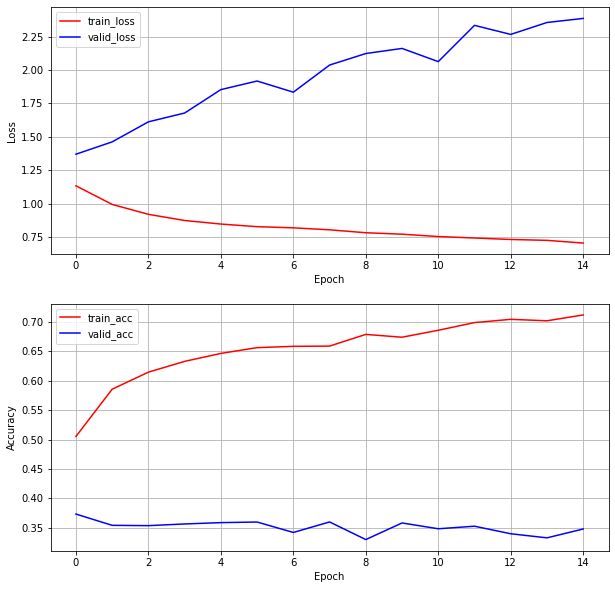

In [0]:
#GPUを使う場合
#dw = 20, dh = 5 epochs = 15
#最初はdw = 300とかでやっていたが、良くて1回しか学習しなかったため、ここまで減らした
#要　20000MiB以上のGPUパワー
dw = 20
dh = 5
max_size = 10

num_dict = len(list((get_counter_dict(X_train))))

#言語処理は1次元データなので、conv1dを使う
#画像処理系は、2次元データであるからconv2dを使って定義していく
#x.viewを入れないとどうなるのかが良くわからなかったので
#比較のために、x.viewを入れないとどうなるのかを試すことにする

class CNN1(torch.nn.Module):
    def __init__(self):
        super(CNN1,self).__init__()
        self.emb = torch.nn.Embedding(num_dict,dw)
        self.conv1d = torch.nn.Conv1d(in_channels = dw,
                                      out_channels = dh,
                                      kernel_size = 3,
                                      stride = 1)
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool1d(max_size)
        self.linear = torch.nn.Linear(dh,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
      #CNNの構造
      #x.sizeは(Batchsize,channel,Height,Width)のタプルを返す
        x = self.emb(x)
        x = self.conv1d(x)
        #x = self.tanh(x)
        x = self.relu(x)
        x = self.pool(x)
        y = self.linear(x)
        #y = self.softmax(y) #クロスエントロピーロス
        return y



class CNN2(torch.nn.Module):
    def __init__(self):
        super(CNN2,self).__init__()
        self.emb = torch.nn.Embedding(num_dict,dw)
        self.conv1d = torch.nn.Conv1d(in_channels = dw,
                                      out_channels = dh,
                                      kernel_size = 3,
                                      padding = 1)
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool1d(max_size)
        self.linear = torch.nn.Linear(dh,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
      #CNNの構造
      #順番としては、Embed ⇒ conv1d ⇒ reluを掛ける(行列のサイズが変わる)　⇒　pooling(max_size分、圧縮)　⇒　Linearに代入
      #x.sizeは(Batchsize,channel,Height,Width)のタプルを返す
      #x.shapeで入力行列のサイズの変換が見れる
      #要するに、次元圧縮等で[a,b,c]のサイズになったら、掛け合わせてa*b*cの形にはreshapeできる
      #reshapeの仕方は、reshape・viewがある
      #なんでこんなことをするかというと、Embedなどの変換をかませた際に行列のサイズがぶれてしまい、Linearに代入できなくなってしまうから
        x = self.emb(x)
        x = x.view(x.shape[0], x.shape[2], x.shape[1])
        #print(x.shape)
        x = self.conv1d(x)
        #print(x.shape)
        #x = self.tanh(x)
        x = self.relu(x)
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(x.shape[0],x.shape[1])
        y = self.linear(x)
        #y = self.softmax(y) #クロスエントロピーロス
        return y

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k


#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = CNN2()

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=16 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(15): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()
    
    t2 = time.time()
    print("今回のエポックの計算時間は" + str(t2-t1))
    
    #trainデータに対して
    Y_train_pred = model(X_train_torch.to(device)) #モデルに突っ込む
    loss_train = loss_fn(Y_train_pred, Y_train_torch.to(device)) #予想と実際のロスの計算
    train_loss.append(loss_train) #配列にappend
    acc_train  = accuracy(Y_train_pred, Y_train_torch.to(device)) #精度の計算
    train_acc.append(acc_train) #配列にappend
    
    #validデータに対して
    Y_valid_pred = model(X_valid_torch.to(device)) #モデルに突っ込む
    loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
    valid_loss.append(loss_valid) #配列にappend
    acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
    valid_acc.append(acc_valid) #配列にappend
    
    t3 = time.time()
    print("今回のロス・精度の計算時間は" + str(t3-t2))
    torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, train_loss, color="red", label="train_loss")
ax[0].plot(epochs, valid_loss, color="blue", label="valid_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, train_acc, color="red", label="train_acc")
ax[1].plot(epochs, valid_acc, color="blue", label="valid_acc")
ax[1].legend(loc=0)

plt.show()

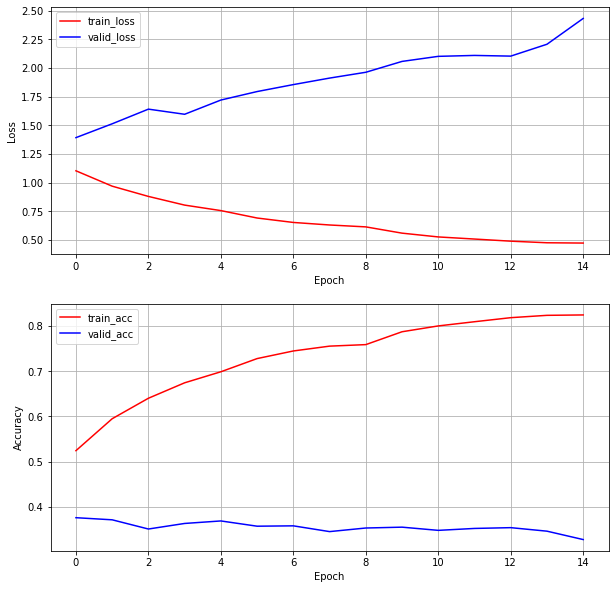

In [0]:
#GPUを使う場合
#dw = 20, dh = 5 epochs = 15
#最初はdw = 300とかでやっていたが、良くて1回しか学習しなかったため、ここまで減らした
#要　20000MiB以上のGPUパワー

#CNNの方は、GPU利用が少なそう？
#色々変えて試してみる

dw = 40
dh = 10
max_size = 10

num_dict = len(list((get_counter_dict(X_train))))

class CNN2(torch.nn.Module):
    def __init__(self):
        super(CNN2,self).__init__()
        self.emb = torch.nn.Embedding(num_dict,dw)
        self.conv1d = torch.nn.Conv1d(in_channels = dw,
                                      out_channels = dh,
                                      kernel_size = 3,
                                      padding = 1)
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool1d(max_size)
        self.linear = torch.nn.Linear(dh,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
      #CNNの構造
      #順番としては、Embed ⇒ conv1d ⇒ reluを掛ける(行列のサイズが変わる)　⇒　pooling(max_size分、圧縮)　⇒　Linearに代入
      #x.sizeは(Batchsize,channel,Height,Width)のタプルを返す
      #x.shapeで入力行列のサイズの変換が見れる
      #要するに、次元圧縮等で[a,b,c]のサイズになったら、掛け合わせてa*b*cの形にはreshapeできる
      #reshapeの仕方は、reshape・viewがある
      #なんでこんなことをするかというと、Embedなどの変換をかませた際に行列のサイズがぶれてしまい、Linearに代入できなくなってしまうから
        x = self.emb(x)
        x = x.view(x.shape[0], x.shape[2], x.shape[1])
        #print(x.shape)
        x = self.conv1d(x)
        #print(x.shape)
        #x = self.tanh(x)
        x = self.relu(x)
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(x.shape[0],x.shape[1])
        y = self.linear(x)
        #y = self.softmax(y) #クロスエントロピーロス
        return y

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k


#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = CNN2()

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=16 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(15): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()
    
    t2 = time.time()
    #print("今回のエポックの計算時間は" + str(t2-t1))
    
    #trainデータに対して
    Y_train_pred = model(X_train_torch.to(device)) #モデルに突っ込む
    loss_train = loss_fn(Y_train_pred, Y_train_torch.to(device)) #予想と実際のロスの計算
    train_loss.append(loss_train) #配列にappend
    acc_train  = accuracy(Y_train_pred, Y_train_torch.to(device)) #精度の計算
    train_acc.append(acc_train) #配列にappend
    
    #validデータに対して
    Y_valid_pred = model(X_valid_torch.to(device)) #モデルに突っ込む
    loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
    valid_loss.append(loss_valid) #配列にappend
    acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
    valid_acc.append(acc_valid) #配列にappend
    
    t3 = time.time()
    #print("今回のロス・精度の計算時間は" + str(t3-t2))
    torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, train_loss, color="red", label="train_loss")
ax[0].plot(epochs, valid_loss, color="blue", label="valid_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, train_acc, color="red", label="train_acc")
ax[1].plot(epochs, valid_acc, color="blue", label="valid_acc")
ax[1].legend(loc=0)

plt.show()

## 第88問

In [0]:
#Google Colabでデータの読み込みを行うときに必要なもの
#最初は以下に飛ばされるので、適宜自分の作業ディレクトリに移動
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/言語処理100本Knocks")

#GPUを止めると、毎回関数等を読み込まなくてはいけないので、必要な関数・ライブラリを一つのファイルにまとめる。
#(第80問を関数で実装したため、200行近くあり、張り付けると見にくい)
#%matplotlibは、マジックコマンドなのでこのファイルには入れられなかった。
#ので、別途実行

#以下を実行すると、変換したtensor行列(X_train_torch, Y_train_torch, X_valid_torch, Y_valid_torch, X_test_torch, Y_test_torch)が得られる
%run -i usual_Part9.py
%matplotlib inline

!nvidia-smi

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:174: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  safe_execfile(fname,*where,**kw)


Fri Jun  5 13:16:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
for i in range(5):
  print(X_train_torch[i])

tensor([ 696,  946,  683,    2,  194, 2081,  921,  661,  661,  661])
tensor([6810, 2624,  399, 3148,    8,   90,  644,  661,  661,  661])
tensor([ 316, 3489, 5451, 1557,   15,    3,  112,    4,   12,   63])
tensor([    3,  9152,    28,  3032,    13, 32216,  4977,    82,   450,   109])
tensor([ 901, 3237, 3664, 1941,  816, 9966,    8, 5452,  661,  661])


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


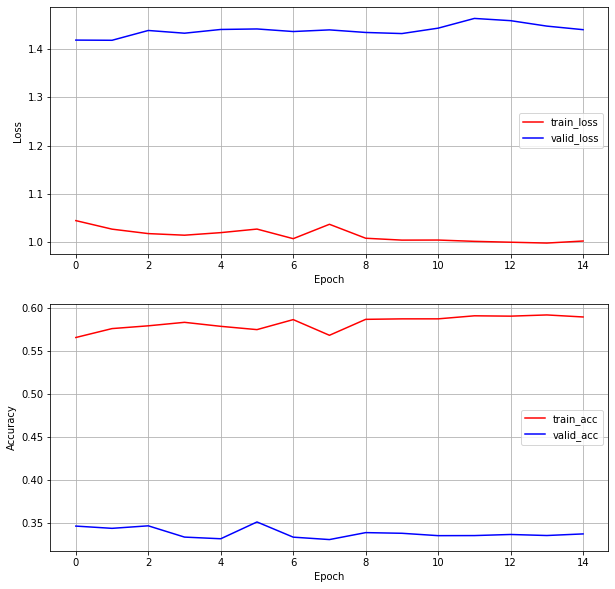

In [0]:
#GPUを使う場合
#dw = 20, dh = 5 epochs = 15
#最初はdw = 300とかでやっていたが、良くて1回しか学習しなかったため、ここまで減らした
#要　20000MiB以上のGPUパワー

#CNNの方は、GPU利用が少なそう？
#色々変えて試してみる

dw = 300
dh = 10
max_size = 10

num_dict = len(list((get_counter_dict(X_train))))

class CNN2(torch.nn.Module):
    def __init__(self):
        super(CNN2,self).__init__()
        model = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary="True")
        weights = torch.FloatTensor(model.vectors)
        self.emb = torch.nn.Embedding.from_pretrained(weights)
        self.conv1d = torch.nn.Conv1d(in_channels = dw,
                                      out_channels = dh,
                                      kernel_size = 3,
                                      padding = 1)
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool1d(max_size)
        self.linear = torch.nn.Linear(dh,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
      #CNNの構造
      #順番としては、Embed ⇒ conv1d ⇒ reluを掛ける(行列のサイズが変わる)　⇒　pooling(max_size分、圧縮)　⇒　Linearに代入
      #x.sizeは(Batchsize,channel,Height,Width)のタプルを返す
      #x.shapeで入力行列のサイズの変換が見れる
      #要するに、次元圧縮等で[a,b,c]のサイズになったら、掛け合わせてa*b*cの形にはreshapeできる
      #reshapeの仕方は、reshape・viewがある
      #なんでこんなことをするかというと、Embedなどの変換をかませた際に行列のサイズがぶれてしまい、Linearに代入できなくなってしまうから
        x = self.emb(x)
        x = x.view(x.shape[0], x.shape[2], x.shape[1])
        #print(x.shape)
        x = self.conv1d(x)
        #print(x.shape)
        #x = self.tanh(x)
        x = self.relu(x)
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(x.shape[0],x.shape[1])
        y = self.linear(x)
        #y = self.softmax(y) #クロスエントロピーロス
        return y

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k


#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = CNN2()

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=16 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(15): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()
    
    t2 = time.time()
    #print("今回のエポックの計算時間は" + str(t2-t1))

    with torch.no_grad(): #こうしないと、メモリがパンクする
    #trainデータに対して
        Y_train_pred = model(X_train_torch.to(device)) #モデルに突っ込む
        loss_train = loss_fn(Y_train_pred, Y_train_torch.to(device)) #予想と実際のロスの計算
        train_loss.append(loss_train) #配列にappend
        acc_train  = accuracy(Y_train_pred, Y_train_torch.to(device)) #精度の計算
        train_acc.append(acc_train) #配列にappend
    
    #validデータに対して
        Y_valid_pred = model(X_valid_torch.to(device)) #モデルに突っ込む
        loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
        valid_loss.append(loss_valid) #配列にappend
        acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
        valid_acc.append(acc_valid) #配列にappend
    
    t3 = time.time()
    #print("今回のロス・精度の計算時間は" + str(t3-t2))
    torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, train_loss, color="red", label="train_loss")
ax[0].plot(epochs, valid_loss, color="blue", label="valid_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, train_acc, color="red", label="train_acc")
ax[1].plot(epochs, valid_acc, color="blue", label="valid_acc")
ax[1].legend(loc=0)

plt.show()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


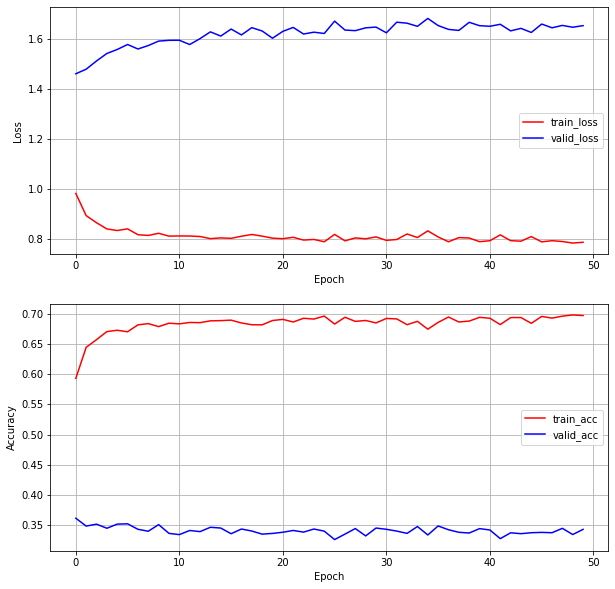

In [0]:
#GPUを使う場合
#dw = 20, dh = 5 epochs = 15
#最初はdw = 300とかでやっていたが、良くて1回しか学習しなかったため、ここまで減らした
#要　20000MiB以上のGPUパワー

#CNNの方は、GPU利用が少なそう？
#色々変えて試してみる

dw = 300
dh = 30
max_size = 10

num_dict = len(list((get_counter_dict(X_train))))

class CNN2(torch.nn.Module):
    def __init__(self):
        super(CNN2,self).__init__()
        model = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary="True")
        weights = torch.FloatTensor(model.vectors)
        self.emb = torch.nn.Embedding.from_pretrained(weights)
        self.conv1d = torch.nn.Conv1d(in_channels = dw,
                                      out_channels = dh,
                                      kernel_size = 3,
                                      padding = 1)
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool1d(max_size)
        self.linear = torch.nn.Linear(dh,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
      #CNNの構造
      #順番としては、Embed ⇒ conv1d ⇒ reluを掛ける(行列のサイズが変わる)　⇒　pooling(max_size分、圧縮)　⇒　Linearに代入
      #x.sizeは(Batchsize,channel,Height,Width)のタプルを返す
      #x.shapeで入力行列のサイズの変換が見れる
      #要するに、次元圧縮等で[a,b,c]のサイズになったら、掛け合わせてa*b*cの形にはreshapeできる
      #reshapeの仕方は、reshape・viewがある
      #なんでこんなことをするかというと、Embedなどの変換をかませた際に行列のサイズがぶれてしまい、Linearに代入できなくなってしまうから
        x = self.emb(x)
        x = x.view(x.shape[0], x.shape[2], x.shape[1])
        #print(x.shape)
        x = self.conv1d(x)
        #print(x.shape)
        #x = self.tanh(x)
        x = self.relu(x)
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(x.shape[0],x.shape[1])
        y = self.linear(x)
        #y = self.softmax(y) #クロスエントロピーロス
        return y

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k


#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = CNN2()

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=16 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(50): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()
    
    t2 = time.time()
    #print("今回のエポックの計算時間は" + str(t2-t1))

    with torch.no_grad(): #こうしないと、メモリがパンクする
    #trainデータに対して
        Y_train_pred = model(X_train_torch.to(device)) #モデルに突っ込む
        loss_train = loss_fn(Y_train_pred, Y_train_torch.to(device)) #予想と実際のロスの計算
        train_loss.append(loss_train) #配列にappend
        acc_train  = accuracy(Y_train_pred, Y_train_torch.to(device)) #精度の計算
        train_acc.append(acc_train) #配列にappend
    
    #validデータに対して
        Y_valid_pred = model(X_valid_torch.to(device)) #モデルに突っ込む
        loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
        valid_loss.append(loss_valid) #配列にappend
        acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
        valid_acc.append(acc_valid) #配列にappend
    
    t3 = time.time()
    #print("今回のロス・精度の計算時間は" + str(t3-t2))
    torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, train_loss, color="red", label="train_loss")
ax[0].plot(epochs, valid_loss, color="blue", label="valid_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, train_acc, color="red", label="train_acc")
ax[1].plot(epochs, valid_acc, color="blue", label="valid_acc")
ax[1].legend(loc=0)

plt.show()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


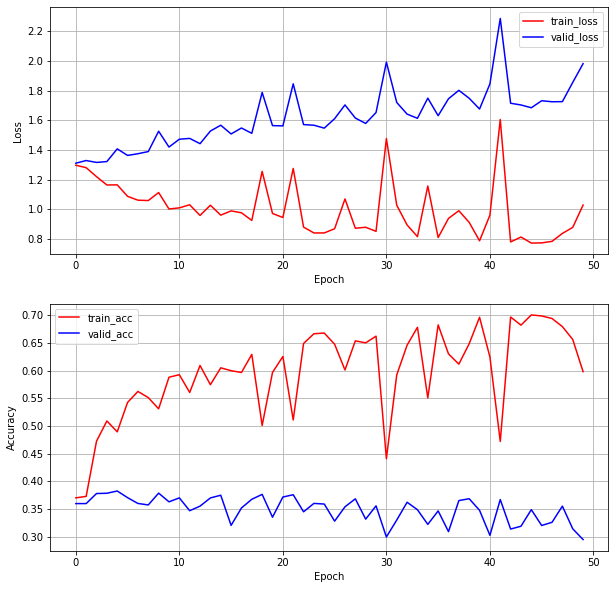

In [0]:
#GPUを使う場合
#dw = 20, dh = 5 epochs = 15
#最初はdw = 300とかでやっていたが、良くて1回しか学習しなかったため、ここまで減らした
#要　20000MiB以上のGPUパワー

#CNNの方は、GPU利用が少なそう？
#色々変えて試してみる

dw = 300
dh = 50
max_size = 10

num_dict = len(list((get_counter_dict(X_train))))

class CNN2(torch.nn.Module):
    def __init__(self):
        super(CNN2,self).__init__()
        model = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary="True")
        weights = torch.FloatTensor(model.vectors)
        self.emb = torch.nn.Embedding.from_pretrained(weights)
        self.conv1d = torch.nn.Conv1d(in_channels = dw,
                                      out_channels = dh,
                                      kernel_size = 3,
                                      padding = 1)
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool1d(max_size)
        self.linear = torch.nn.Linear(dh,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
      #CNNの構造
      #順番としては、Embed ⇒ conv1d ⇒ reluを掛ける(行列のサイズが変わる)　⇒　pooling(max_size分、圧縮)　⇒　Linearに代入
      #x.sizeは(Batchsize,channel,Height,Width)のタプルを返す
      #x.shapeで入力行列のサイズの変換が見れる
      #要するに、次元圧縮等で[a,b,c]のサイズになったら、掛け合わせてa*b*cの形にはreshapeできる
      #reshapeの仕方は、reshape・viewがある
      #なんでこんなことをするかというと、Embedなどの変換をかませた際に行列のサイズがぶれてしまい、Linearに代入できなくなってしまうから
        x = self.emb(x)
        x = x.view(x.shape[0], x.shape[2], x.shape[1])
        #print(x.shape)
        x = self.conv1d(x)
        #print(x.shape)
        x = self.relu(x)
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(x.shape[0],x.shape[1])
        y = self.linear(x)
        #y = self.softmax(y) #クロスエントロピーロス
        return y

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k


#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = CNN2()

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=1024 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(50): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()
    
    t2 = time.time()
    #print("今回のエポックの計算時間は" + str(t2-t1))

    with torch.no_grad(): #こうしないと、メモリがパンクする
    #trainデータに対して
        Y_train_pred = model(X_train_torch.to(device)) #モデルに突っ込む
        loss_train = loss_fn(Y_train_pred, Y_train_torch.to(device)) #予想と実際のロスの計算
        train_loss.append(loss_train) #配列にappend
        acc_train  = accuracy(Y_train_pred, Y_train_torch.to(device)) #精度の計算
        train_acc.append(acc_train) #配列にappend
    
    #validデータに対して
        Y_valid_pred = model(X_valid_torch.to(device)) #モデルに突っ込む
        loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
        valid_loss.append(loss_valid) #配列にappend
        acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
        valid_acc.append(acc_valid) #配列にappend
    
    t3 = time.time()
    #print("今回のロス・精度の計算時間は" + str(t3-t2))
    torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, train_loss, color="red", label="train_loss")
ax[0].plot(epochs, valid_loss, color="blue", label="valid_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, train_acc, color="red", label="train_acc")
ax[1].plot(epochs, valid_acc, color="blue", label="valid_acc")
ax[1].legend(loc=0)

plt.show()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


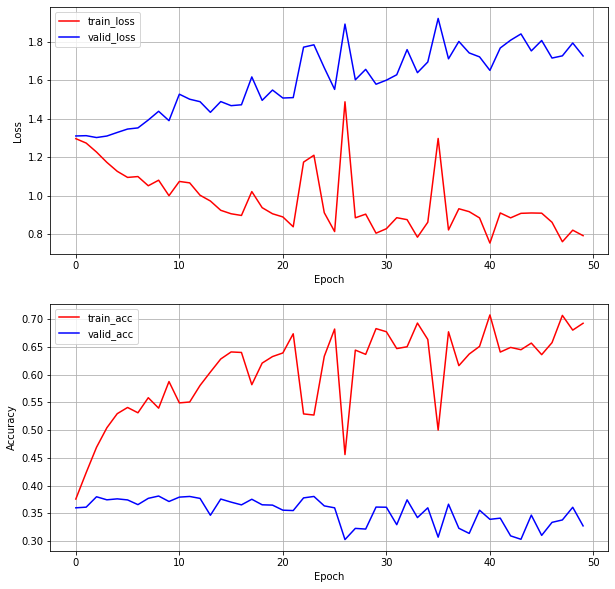

In [0]:
#GPUを使う場合

#CNNの方は、GPU利用が少なそう？
#色々変えて試してみる

dw = 300
dh = 50
max_size = 10

num_dict = len(list((get_counter_dict(X_train))))

class CNN2(torch.nn.Module):
    def __init__(self):
        super(CNN2,self).__init__()
        model = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary="True")
        weights = torch.FloatTensor(model.vectors)
        self.emb = torch.nn.Embedding.from_pretrained(weights)
        self.conv1d = torch.nn.Conv1d(in_channels = dw,
                                      out_channels = dh,
                                      kernel_size = 3,
                                      padding = 1)
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool1d(max_size)
        self.linear = torch.nn.Linear(dh,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
      #CNNの構造
      #順番としては、Embed ⇒ conv1d ⇒ reluを掛ける(行列のサイズが変わる)　⇒　pooling(max_size分、圧縮)　⇒　Linearに代入
      #x.sizeは(Batchsize,channel,Height,Width)のタプルを返す
      #x.shapeで入力行列のサイズの変換が見れる
      #要するに、次元圧縮等で[a,b,c]のサイズになったら、掛け合わせてa*b*cの形にはreshapeできる
      #reshapeの仕方は、reshape・viewがある
      #なんでこんなことをするかというと、Embedなどの変換をかませた際に行列のサイズがぶれてしまい、Linearに代入できなくなってしまうから
        x = self.emb(x)
        x = x.view(x.shape[0], x.shape[2], x.shape[1])
        #print(x.shape)
        x = self.conv1d(x)
        #print(x.shape)
        x = self.relu(x)
        #print(x.shape)
        x = self.tanh(x)
        #print(x.shape)        
        x = self.pool(x)
        #print(x.shape)
        x = self.relu(x)
        #print(x.shape)
        x = x.view(x.shape[0],x.shape[1])
        y = self.linear(x)
        #y = self.softmax(y) #クロスエントロピーロス
        return y

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k


#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = CNN2()

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=1024 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(50): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()
    
    t2 = time.time()
    #print("今回のエポックの計算時間は" + str(t2-t1))

    with torch.no_grad(): #こうしないと、メモリがパンクする
    #trainデータに対して
        Y_train_pred = model(X_train_torch.to(device)) #モデルに突っ込む
        loss_train = loss_fn(Y_train_pred, Y_train_torch.to(device)) #予想と実際のロスの計算
        train_loss.append(loss_train) #配列にappend
        acc_train  = accuracy(Y_train_pred, Y_train_torch.to(device)) #精度の計算
        train_acc.append(acc_train) #配列にappend
    
    #validデータに対して
        Y_valid_pred = model(X_valid_torch.to(device)) #モデルに突っ込む
        loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
        valid_loss.append(loss_valid) #配列にappend
        acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
        valid_acc.append(acc_valid) #配列にappend
    
    t3 = time.time()
    #print("今回のロス・精度の計算時間は" + str(t3-t2))
    torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, train_loss, color="red", label="train_loss")
ax[0].plot(epochs, valid_loss, color="blue", label="valid_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, train_acc, color="red", label="train_acc")
ax[1].plot(epochs, valid_acc, color="blue", label="valid_acc")
ax[1].legend(loc=0)

plt.show()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


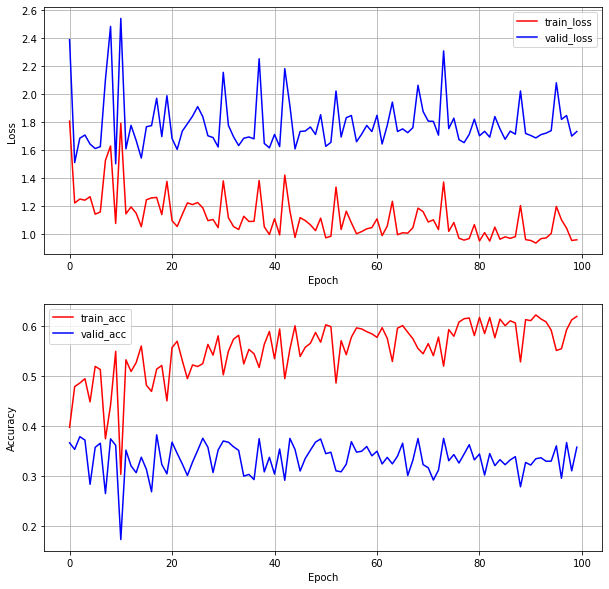

In [0]:
#GPUを使う場合

#CNNの方は、GPU利用が少なそう？
#色々変えて試してみる

#optimをAdamに変更
#Dropoutを追加

dw = 300
dh = 100
max_size = 10

num_dict = len(list((get_counter_dict(X_train))))

class CNN2(torch.nn.Module):
    def __init__(self):
        super(CNN2,self).__init__()
        model = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary="True")
        weights = torch.FloatTensor(model.vectors)
        self.emb = torch.nn.Embedding.from_pretrained(weights)
        self.conv1d = torch.nn.Conv1d(in_channels = dw,
                                      out_channels = dh,
                                      kernel_size = 3,
                                      padding = 1)
        self.dropout = torch.nn.Dropout(p=0.2)
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool1d(max_size)
        self.linear = torch.nn.Linear(dh,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
      #CNNの構造
      #順番としては、Embed ⇒ conv1d ⇒ reluを掛ける(行列のサイズが変わる)　⇒　pooling(max_size分、圧縮)　⇒　Linearに代入
      #x.sizeは(Batchsize,channel,Height,Width)のタプルを返す
      #x.shapeで入力行列のサイズの変換が見れる
      #要するに、次元圧縮等で[a,b,c]のサイズになったら、掛け合わせてa*b*cの形にはreshapeできる
      #reshapeの仕方は、reshape・viewがある
      #なんでこんなことをするかというと、Embedなどの変換をかませた際に行列のサイズがぶれてしまい、Linearに代入できなくなってしまうから
        x = self.emb(x)
        x = x.view(x.shape[0], x.shape[2], x.shape[1])
        #print(x.shape)
        x = self.conv1d(x)
        #print(x.shape)
        x = self.relu(x)
        #print(x.shape)
        x = self.dropout(x)
        #print(x.shape)
        x = self.tanh(x)
        #print(x.shape)        
        x = self.pool(x)
        #print(x.shape)
        x = self.relu(x)
        #print(x.shape)
        x = x.view(x.shape[0],x.shape[1])
        y = self.linear(x)
        #y = self.softmax(y) #クロスエントロピーロス
        return y

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k


#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = CNN2()

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=1024 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(100): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()
    
    t2 = time.time()
    #print("今回のエポックの計算時間は" + str(t2-t1))

    with torch.no_grad(): #こうしないと、メモリがパンクする
    #trainデータに対して
        Y_train_pred = model(X_train_torch.to(device)) #モデルに突っ込む
        loss_train = loss_fn(Y_train_pred, Y_train_torch.to(device)) #予想と実際のロスの計算
        train_loss.append(loss_train) #配列にappend
        acc_train  = accuracy(Y_train_pred, Y_train_torch.to(device)) #精度の計算
        train_acc.append(acc_train) #配列にappend
    
    #validデータに対して
        Y_valid_pred = model(X_valid_torch.to(device)) #モデルに突っ込む
        loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
        valid_loss.append(loss_valid) #配列にappend
        acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
        valid_acc.append(acc_valid) #配列にappend
    
    t3 = time.time()
    #print("今回のロス・精度の計算時間は" + str(t3-t2))
    torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, train_loss, color="red", label="train_loss")
ax[0].plot(epochs, valid_loss, color="blue", label="valid_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, train_acc, color="red", label="train_acc")
ax[1].plot(epochs, valid_acc, color="blue", label="valid_acc")
ax[1].legend(loc=0)

plt.show()

## 第89問

【やること】

BERTによる転移学習だが、
https://qiita.com/kenta1984/items/7f3a5d859a15b20657f3
によると、

すでに学習済みのモデルがあることが読み取れる。

要するに、今までは頻度順によって割り振っていたIdを、

BERTモデルに準拠したIdの割り振り方法に変更するものだと、解釈する。

つまり、X_train_torchなどの生成を変えるということであるから、

usual_Part9.pyを変更することで、Idの割り振り方法を変えた変数を

新たに生成するということである。(X_train_torch_Pull_bと同じ)

⇒【追記】学習モデルも、CNNではなくBERTモデルに変えなければいけない



In [0]:
#transformersをインストール
!pip install transformers

In [0]:
#Mecabのインストール
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

Reading package lists... Done
^C
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
git is already installed at the requested version (1:2.17.1-1ubuntu0.7)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.8)
xz-utils is already installed at the requested version (5.2.2-1.3)
file is already installed at the requested version (1:5.32-2ubuntu0.4)
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
git is already installed at the requested version (1:2.17.1-1ubuntu0.7)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the request

In [0]:
#Google Colabでデータの読み込みを行うときに必要なもの
#最初は以下に飛ばされるので、適宜自分の作業ディレクトリに移動
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/言語処理100本Knocks")

#GPUを止めると、毎回関数等を読み込まなくてはいけないので、必要な関数・ライブラリを一つのファイルにまとめる。
#(第80問を関数で実装したため、200行近くあり、張り付けると見にくい)
#%matplotlibは、マジックコマンドなのでこのファイルには入れられなかった。
#ので、別途実行

#以下を実行すると、変換したtensor行列(X_train_torch, Y_train_torch, X_valid_torch, Y_valid_torch, X_test_torch, Y_test_torch)が得られる
%run -i usual_Part9.py
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:174: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  safe_execfile(fname,*where,**kw)


In [0]:
!nvidia-smi

Thu Jun 11 20:06:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


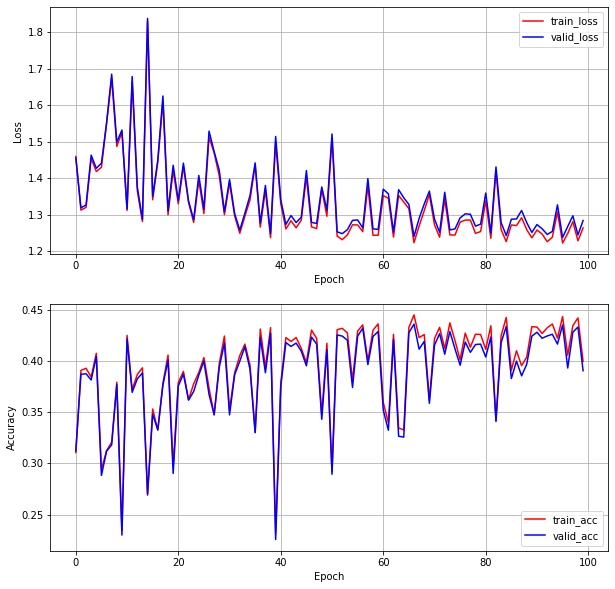

In [0]:
#GPUを使う場合

#CNNの方は、GPU利用が少なそう？
#色々変えて試してみる

#optimをAdamに変更
#Dropoutを追加

dw = 300
dh = 100
max_size = 10

num_dict = len(list((get_counter_dict(X_train))))

class CNN2(torch.nn.Module):
    def __init__(self):
        super(CNN2,self).__init__()
        model = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary="True")
        weights = torch.FloatTensor(model.vectors)
        self.emb = torch.nn.Embedding.from_pretrained(weights)
        self.conv1d = torch.nn.Conv1d(in_channels = dw,
                                      out_channels = dh,
                                      kernel_size = 3,
                                      padding = 1)
        self.dropout = torch.nn.Dropout(p=0.2)
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool1d(max_size)
        self.linear = torch.nn.Linear(dh,4)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x, h = None):
      #CNNの構造
      #順番としては、Embed ⇒ conv1d ⇒ reluを掛ける(行列のサイズが変わる)　⇒　pooling(max_size分、圧縮)　⇒　Linearに代入
      #x.sizeは(Batchsize,channel,Height,Width)のタプルを返す
      #x.shapeで入力行列のサイズの変換が見れる
      #要するに、次元圧縮等で[a,b,c]のサイズになったら、掛け合わせてa*b*cの形にはreshapeできる
      #reshapeの仕方は、reshape・viewがある
      #なんでこんなことをするかというと、Embedなどの変換をかませた際に行列のサイズがぶれてしまい、Linearに代入できなくなってしまうから
        x = self.emb(x)
        x = x.view(x.shape[0], x.shape[2], x.shape[1])
        #print(x.shape)
        x = self.conv1d(x)
        #print(x.shape)
        x = self.relu(x)
        #print(x.shape)
        x = self.dropout(x)
        #print(x.shape)
        x = self.tanh(x)
        #print(x.shape)        
        x = self.pool(x)
        #print(x.shape)
        x = self.relu(x)
        #print(x.shape)
        x = x.view(x.shape[0],x.shape[1])
        y = self.linear(x)
        #y = self.softmax(y) #クロスエントロピーロス
        return y

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k


#以下、第8章からの移植(modelのみRNNに変更)
#モデルの作成
model = CNN2()

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
DataSet = TensorDataset(X_train_torch_bert.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=1024 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(100): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        y_pred = model(xx) #モデルから予想するよ
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()
    
    t2 = time.time()
    #print("今回のエポックの計算時間は" + str(t2-t1))

    with torch.no_grad(): #こうしないと、メモリがパンクする
    #trainデータに対して
        Y_train_pred = model(X_train_torch_bert.to(device)) #モデルに突っ込む
        loss_train = loss_fn(Y_train_pred, Y_train_torch.to(device)) #予想と実際のロスの計算
        train_loss.append(loss_train) #配列にappend
        acc_train  = accuracy(Y_train_pred, Y_train_torch.to(device)) #精度の計算
        train_acc.append(acc_train) #配列にappend
    
    #validデータに対して
        Y_valid_pred = model(X_valid_torch_bert.to(device)) #モデルに突っ込む
        loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
        valid_loss.append(loss_valid) #配列にappend
        acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
        valid_acc.append(acc_valid) #配列にappend
    
    t3 = time.time()
    #print("今回のロス・精度の計算時間は" + str(t3-t2))
    torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].plot(epochs, train_loss, color="red", label="train_loss")
ax[0].plot(epochs, valid_loss, color="blue", label="valid_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
ax[1].plot(epochs, train_acc, color="red", label="train_acc")
ax[1].plot(epochs, valid_acc, color="blue", label="valid_acc")
ax[1].legend(loc=0)

plt.show()

In [0]:
print(X_valid_torch_bert[3])
print(Y_valid_torch[3])

tensor([2047, 2188, 4341, 2012, 1019, 3204, 2659, 1999, 2337,    1])
tensor(0)


In [0]:
#GPUを使う場合

#CNNの方は、GPU利用が少なそう？
#色々変えて試してみる

#optimをAdamに変更
#Dropoutを追加

#BERTはめちゃくちゃGPUを食うらしい
#また、そもそものtrainデータの量も多いので、一部のことをCPUになげることにする
#⇒時間かかり過ぎで、Colabから追い出されそう

max_size = 10

#-----------------モデルの用意---------------------------------

from transformers.modeling_bert import BertModel

class BERTClassifier(torch.nn.Module):

  def __init__(self):
    super(BERTClassifier,self).__init__()
    self.bert = BertModel.from_pretrained("bert-base-uncased")
    self.linear = torch.nn.Linear(768,4) #bertのinputは768,出力は4クラス分

    #torch.nn.init.normal_(self.linear.weight, std=0.02)
    #torch.nn.init.normal_(self.linear.bias, 0)
  
  def forward(self,x):
    result = self.bert(x)
    y = result[0]
    y = y[:,0,:]
    y = y.view(-1,768)
    output = self.linear(y)

    return output


def dfs_freeze(model):
    for name, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = False
        dfs_freeze(child)

#---------------------------------------------------------------

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k

#モデルの読み込み
model = BERTClassifier()


#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


#device = torch.device("cpu")

model = model.to(device)

dfs_freeze(model)
model.fc.requires_grad_(True)

DataSet = TensorDataset(X_train_torch_bert.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=16 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

#モデルに突っ込む部分をcpuに投げることで
#GPUの負荷を下げることを目指してみる
# device = torch.device("cpu")
# model.to(device)

for epoch in range(3): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        
        y_pred = model(xx)
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()
        del loss,xx,yy,y_pred
    
    t2 = time.time()
    print("今回のエポックの計算時間は" + str(t2-t1))
    #device = torch.device("cuda")
    #model = model.to(device)

    with torch.no_grad(): #こうしないと、メモリがパンクする
        '''
        #trainデータに対して
        Y_train_pred = model(X_train_torch_bert.to(device)) #モデルに突っ込む
        loss_train = loss_fn(Y_train_pred, Y_train_torch.to(device)) #予想と実際のロスの計算
        train_loss.append(loss_train) #配列にappend
        acc_train  = accuracy(Y_train_pred, Y_train_torch.to(device)) #精度の計算
        train_acc.append(acc_train) #配列にappend
        '''

    #validデータに対して
        Y_valid_pred = model(X_valid_torch_bert.to(device)) #モデルに突っ込む
        loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
        valid_loss.append(loss_valid) #配列にappend
        acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
        valid_acc.append(acc_valid) #配列にappend
    
    t3 = time.time()
    #print("今回のロス・精度の計算時間は" + str(t3-t2))
    torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
#ax[0].plot(epochs, train_loss, color="red", label="train_loss")
ax[0].plot(epochs, valid_loss, color="blue", label="valid_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
#ax[1].plot(epochs, train_acc, color="red", label="train_acc")
ax[1].plot(epochs, valid_acc, color="blue", label="valid_acc")
ax[1].legend(loc=0)

plt.show()

今回のエポックの計算時間は1288.5945448875427


RuntimeError: ignored

In [0]:
print(X_train_torch[0])
print(Y_train_torch[0])
print(X_train_torch_bert[0])

tensor([ 696,  946,  683,    2,  194, 2081,  921,  661,  661,  661])
tensor(1)
tensor([11742,  6561,  4093,  1999,   100])



今回のエポックの計算時間は132.9084017276764
今回のエポックの計算時間は135.72702145576477
今回のエポックの計算時間は134.51929259300232


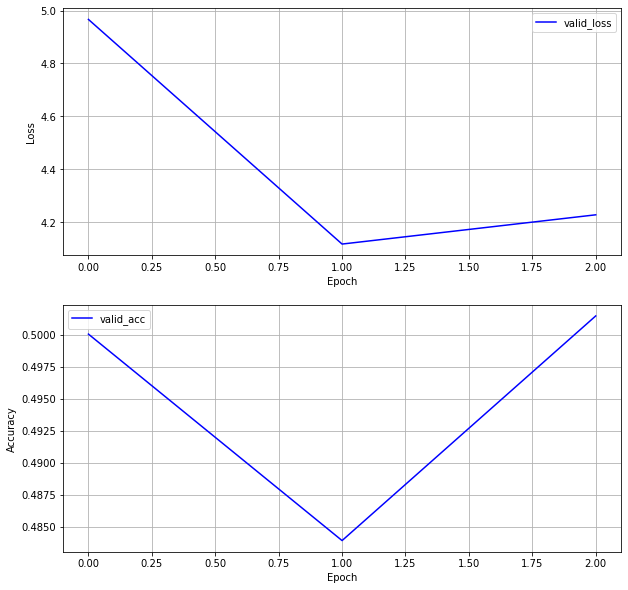

In [0]:
#GPUを使う場合

#CNNの方は、GPU利用が少なそう？
#色々変えて試してみる

#optimをAdamに変更
#Dropoutを追加

#BERTはめちゃくちゃGPUを食うらしい
#また、そもそものtrainデータの量も多いので、一部のことをCPUになげることにする
#⇒時間かかり過ぎで、Colabから追い出されそう

max_size = 5

#-----------------モデルの用意---------------------------------

from transformers.modeling_bert import BertModel

tokenizer_class = BertTokenizer
tokenizer = tokenizer_class.from_pretrained('bert-base-uncased')

class BERTClassifier(torch.nn.Module):

  def __init__(self):
    super(BERTClassifier,self).__init__()
    self.bert = BertModel.from_pretrained("bert-base-uncased")
    self.linear = torch.nn.Linear(768,4) #bertのinputは768,出力は4クラス分

    #torch.nn.init.normal_(self.linear.weight, std=0.02)
    #torch.nn.init.normal_(self.linear.bias, 0)
  
  def forward(self,x):
    result = self.bert(x)
    y = result[0]
    y = y[:,0,:]
    y = y.view(-1,768)
    output = self.linear(y)

    return output


def dfs_freeze(model):
    for name, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = False
        dfs_freeze(child)

#---------------------------------------------------------------

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k

#モデルの読み込み
model = BERTClassifier()


#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


#device = torch.device("cpu")

model = model.to(device)

dfs_freeze(model)
model.linear.requires_grad_(True)

DataSet = TensorDataset(X_train_torch_bert.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=32 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

#モデルに突っ込む部分をcpuに投げることで
#GPUの負荷を下げることを目指してみる
# device = torch.device("cpu")
# model.to(device)

for epoch in range(3): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        
        y_pred = model(xx)
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()
        del loss,xx,yy,y_pred
    
    t2 = time.time()
    print("今回のエポックの計算時間は" + str(t2-t1))
    #device = torch.device("cuda")
    #model = model.to(device)

    with torch.no_grad(): #こうしないと、メモリがパンクする
        '''
        #trainデータに対して
        Y_train_pred = model(X_train_torch_bert.to(device)) #モデルに突っ込む
        loss_train = loss_fn(Y_train_pred, Y_train_torch.to(device)) #予想と実際のロスの計算
        train_loss.append(loss_train) #配列にappend
        acc_train  = accuracy(Y_train_pred, Y_train_torch.to(device)) #精度の計算
        train_acc.append(acc_train) #配列にappend
        '''

    #validデータに対して
        Y_valid_pred = model(X_valid_torch_bert.to(device)) #モデルに突っ込む
        loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
        valid_loss.append(loss_valid) #配列にappend
        acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
        valid_acc.append(acc_valid) #配列にappend
    
    t3 = time.time()
    #print("今回のロス・精度の計算時間は" + str(t3-t2))
    torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
#ax[0].plot(epochs, train_loss, color="red", label="train_loss")
ax[0].plot(epochs, valid_loss, color="blue", label="valid_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
#ax[1].plot(epochs, train_acc, color="red", label="train_acc")
ax[1].plot(epochs, valid_acc, color="blue", label="valid_acc")
ax[1].legend(loc=0)

plt.show()

In [0]:
!nvidia-smi

Wed Jun 10 06:02:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    34W /  70W |   1365MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

今回のエポックの計算時間は136.2323591709137
今回のエポックの計算時間は133.9620635509491
今回のエポックの計算時間は135.64245080947876
今回のエポックの計算時間は134.18069863319397
今回のエポックの計算時間は136.2684190273285
今回のエポックの計算時間は134.77446866035461
今回のエポックの計算時間は136.4386043548584
今回のエポックの計算時間は134.81135082244873
今回のエポックの計算時間は136.10077953338623
今回のエポックの計算時間は134.4820773601532
今回のエポックの計算時間は136.26246666908264
今回のエポックの計算時間は134.64797687530518
今回のエポックの計算時間は136.22443413734436
今回のエポックの計算時間は134.53662824630737
今回のエポックの計算時間は135.7798194885254
今回のエポックの計算時間は134.3108479976654
今回のエポックの計算時間は135.95722913742065
今回のエポックの計算時間は134.65718913078308
今回のエポックの計算時間は136.22902989387512
今回のエポックの計算時間は134.23751544952393


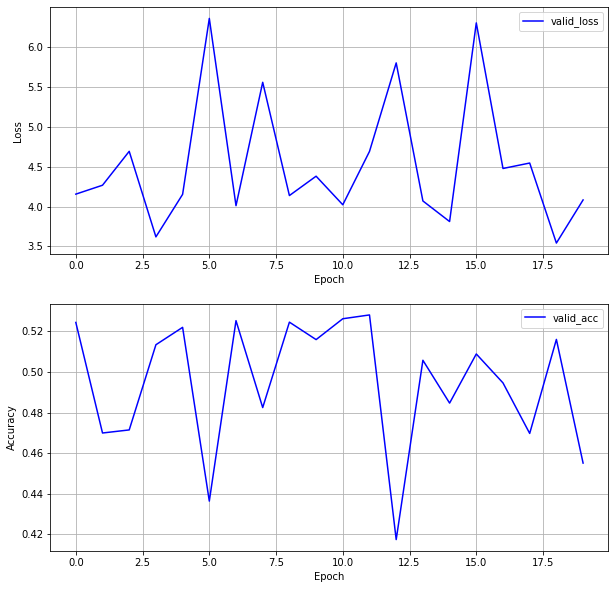

In [0]:
#GPUを使う場合

#CNNの方は、GPU利用が少なそう？
#色々変えて試してみる

#optimをAdamに変更
#Dropoutを追加

#BERTはめちゃくちゃGPUを食うらしい
#また、そもそものtrainデータの量も多いので、一部のことをCPUになげることにする
#⇒時間かかり過ぎで、Colabから追い出されそう

#しょうがないからmax_sizeを変える
max_size = 5

#-----------------モデルの用意---------------------------------

from transformers.modeling_bert import BertModel

tokenizer_class = BertTokenizer
tokenizer = tokenizer_class.from_pretrained('bert-base-uncased')

class BERTClassifier(torch.nn.Module):

  def __init__(self):
    super(BERTClassifier,self).__init__()
    self.bert = BertModel.from_pretrained("bert-base-uncased")
    self.linear = torch.nn.Linear(768,4) #bertのinputは768,出力は4クラス分

    #torch.nn.init.normal_(self.linear.weight, std=0.02)
    #torch.nn.init.normal_(self.linear.bias, 0)
  
  def forward(self,x):
    result = self.bert(x)
    y = result[0]
    y = y[:,0,:]
    y = y.view(-1,768)
    output = self.linear(y)

    return output


def dfs_freeze(model):
    for name, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = False
        dfs_freeze(child)

#---------------------------------------------------------------

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k

#モデルの読み込み
model = BERTClassifier()


#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


#device = torch.device("cpu")

model = model.to(device)

dfs_freeze(model)
model.linear.requires_grad_(True)

DataSet = TensorDataset(X_train_torch_bert.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=32 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

#モデルに突っ込む部分をcpuに投げることで
#GPUの負荷を下げることを目指してみる
# device = torch.device("cpu")
# model.to(device)

for epoch in range(20): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()
    
    for xx,yy in Loader: #データはloader内に入っているモノ
        
        y_pred = model(xx)
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()
        del loss,xx,yy,y_pred
    
    t2 = time.time()
    print("今回のエポックの計算時間は" + str(t2-t1))
    #device = torch.device("cuda")
    #model = model.to(device)

    with torch.no_grad(): #こうしないと、メモリがパンクする
        '''
        #trainデータに対して
        Y_train_pred = model(X_train_torch_bert.to(device)) #モデルに突っ込む
        loss_train = loss_fn(Y_train_pred, Y_train_torch.to(device)) #予想と実際のロスの計算
        train_loss.append(loss_train) #配列にappend
        acc_train  = accuracy(Y_train_pred, Y_train_torch.to(device)) #精度の計算
        train_acc.append(acc_train) #配列にappend
        '''

    #validデータに対して
        Y_valid_pred = model(X_valid_torch_bert.to(device)) #モデルに突っ込む
        loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
        valid_loss.append(loss_valid) #配列にappend
        acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
        valid_acc.append(acc_valid) #配列にappend
    
    t3 = time.time()
    #print("今回のロス・精度の計算時間は" + str(t3-t2))
    torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
#ax[0].plot(epochs, train_loss, color="red", label="train_loss")
ax[0].plot(epochs, valid_loss, color="blue", label="valid_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
#ax[1].plot(epochs, train_acc, color="red", label="train_acc")
ax[1].plot(epochs, valid_acc, color="blue", label="valid_acc")
ax[1].legend(loc=0)

plt.show()

今回のエポックの計算時間は330.4375636577606
今回のエポックの計算時間は330.2878727912903
今回のエポックの計算時間は330.50002932548523
今回のエポックの計算時間は330.67531514167786
今回のエポックの計算時間は331.1035158634186
今回のエポックの計算時間は330.2339949607849
今回のエポックの計算時間は330.0647945404053
今回のエポックの計算時間は330.1008565425873
今回のエポックの計算時間は329.84383249282837
今回のエポックの計算時間は329.75881600379944
今回のエポックの計算時間は329.8234555721283
今回のエポックの計算時間は330.0146815776825
今回のエポックの計算時間は330.35293102264404
今回のエポックの計算時間は330.3188548088074
今回のエポックの計算時間は330.3039722442627
今回のエポックの計算時間は330.4440095424652
今回のエポックの計算時間は330.5851912498474
今回のエポックの計算時間は330.7728621959686
今回のエポックの計算時間は330.65745735168457
今回のエポックの計算時間は330.8655550479889


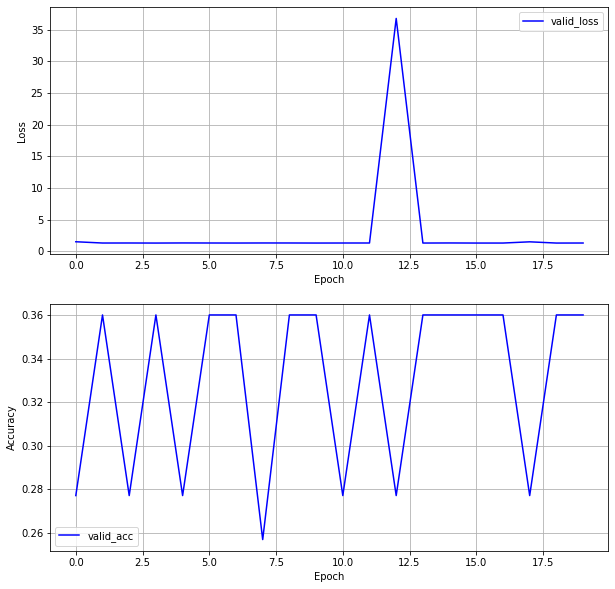

In [0]:
#GPUを使う場合

#CNNの方は、GPU利用が少なそう？
#色々変えて試してみる

#optimをAdamに変更
#Dropoutを追加

#BERTはめちゃくちゃGPUを食うらしい
#また、そもそものtrainデータの量も多いので、一部のことをCPUになげることにする
#⇒時間かかり過ぎで、Colabから追い出されそう

#しょうがないからmax_sizeを変える
max_size = 6

X_train_torch_bert = Change_BERT_Tensor(X_train,max_size)
X_valid_torch_bert = Change_BERT_Tensor(X_valid,max_size)

#-----------------モデルの用意---------------------------------

from transformers.modeling_bert import BertModel

tokenizer_class = BertTokenizer
tokenizer = tokenizer_class.from_pretrained('bert-base-uncased')

class BERTClassifier(torch.nn.Module):

  def __init__(self):
    super(BERTClassifier,self).__init__()
    self.bert = BertModel.from_pretrained("bert-base-uncased")
    self.linear = torch.nn.Linear(768,4) #bertのinputは768,出力は4クラス分

    #torch.nn.init.normal_(self.linear.weight, std=0.02)
    #torch.nn.init.normal_(self.linear.bias, 0)
  
  def forward(self,x):
    result = self.bert(x)
    y = result[0]
    y = y[:,0,:]
    y = y.view(-1,768)
    output = self.linear(y)

    return output


def dfs_freeze(model):
    for name, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = False
        dfs_freeze(child)

#---------------------------------------------------------------

def accuracy(pred,real):
    pred = np.argmax(pred.data.cpu().numpy(),axis=1)
    real = real.data.cpu().numpy()
    sum_acc = 0
    for p,r in zip(pred, real):
        if p == r:
            sum_acc += 1
    k = sum_acc / len(real)
    return k

#モデルの読み込み
model = BERTClassifier()

#GPUでの学習に変更
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


#device = torch.device("cpu")

model = model.to(device)

#dfs_freeze(model)
#model.linear.requires_grad_(True)

DataSet = TensorDataset(X_train_torch_bert.to(device), Y_train_torch.to(device))
Loader = DataLoader(DataSet,batch_size=128 ,shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-1)

#pltで簡単に作ることにする
epochs = []
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

#モデルに突っ込む部分をcpuに投げることで
#GPUの負荷を下げることを目指してみる
# device = torch.device("cpu")
# model.to(device)

for epoch in range(20): #epoch数をn回にする
    #一応epoch数もラベルとして使うので、格納
    epochs.append(epoch)
    
    t1 = time.time()

    for xx,yy in Loader: #データはloader内に入っているモノ
        
        y_pred = model(xx)
        loss = loss_fn(y_pred, yy) #lossを計算
        optimizer.zero_grad() #勾配の初期化
        loss.backward() #ロスの計算
        optimizer.step() #パラメータの更新
        torch.cuda.empty_cache()
        del loss,xx,yy,y_pred
    
    t2 = time.time()
    print("今回のエポックの計算時間は" + str(t2-t1))
    #device = torch.device("cuda")
    #model = model.to(device)

    with torch.no_grad(): #こうしないと、メモリがパンクする

        '''
        #trainデータに対して
        Y_train_pred = model(X_train_torch_bert.to(device)) #モデルに突っ込む
        loss_train = loss_fn(Y_train_pred, Y_train_torch.to(device)) #予想と実際のロスの計算
        train_loss.append(loss_train) #配列にappend
        acc_train  = accuracy(Y_train_pred, Y_train_torch.to(device)) #精度の計算
        train_acc.append(acc_train) #配列にappend
        '''

        #validデータに対して
        Y_valid_pred = model(X_valid_torch_bert.to(device)) #モデルに突っ込む
        loss_valid = loss_fn(Y_valid_pred, Y_valid_torch.to(device)) #予想と実際のロスの計算
        valid_loss.append(loss_valid) #配列にappend
        acc_valid  = accuracy(Y_valid_pred, Y_valid_torch.to(device)) #精度の計算
        valid_acc.append(acc_valid) #配列にappend
    
    t3 = time.time()
    #print("今回のロス・精度の計算時間は" + str(t3-t2))
    torch.cuda.empty_cache()

#横軸にepoch数、縦軸にlossとaccuracyを取ったグラフを書く
fig, ax = plt.subplots(2,1,figsize=(10,10))
#EpochとLoss
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
#ax[0].plot(epochs, train_loss, color="red", label="train_loss")
ax[0].plot(epochs, valid_loss, color="blue", label="valid_loss")
ax[0].legend(loc=0)
#Epochとaccuracy
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()
#ax[1].plot(epochs, train_acc, color="red", label="train_acc")
ax[1].plot(epochs, valid_acc, color="blue", label="valid_acc")
ax[1].legend(loc=0)

plt.show()